In [1]:
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2016-building-energy-benchmarking.json
/kaggle/input/sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2015-building-energy-benchmarking.json


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as st

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Functions

In [3]:
# Function to reduce memory usage:
def reduce_memory_usage(df):
    # Print memory usage before changing datatypes
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    # Change datatypes
    for col in df.columns:
        col_type = df[col].dtype
        
        # Change datatypes only for integers or floats
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Change datatypes for integers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            # Change datatypes for floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # Print memory usage after changing datatypes
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage now : {:.2f} MB'.format(end_mem)) 
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
# Function to display all the columns and rows
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 200
    display.max_rows = 200
    display.max_colwidth = 200
    display.width = None
    
# Function to display values on countplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        

# Function to display countplots
def display_countplot(df, x):
    plt.figure(figsize=(15,4))
    sns.set_theme(style="darkgrid")

    g = sns.countplot(x=x, data=df)

    plt.yticks(fontsize=15)
    plt.xlabel(x, size=16)
    plt.ylabel("Count", size=15)
    plt.title(f"Count of properties by {x}", fontsize=20)
    
    if len(df[x].unique().tolist()) < 50:
        plt.xticks(fontsize=16, rotation=90)
        show_values(g);
    else:
        plt.xticks(fontsize=10, rotation=90)

# Boxplot
def display_boxplot(df, x, y, showfliers=True):
    order = df.groupby(y)[x].median().sort_values(ascending=False).index
    
    if len(df[y].unique().tolist()) < 30:
        plt.figure(figsize=(10,5))
    else:
        plt.figure(figsize=(10,10))
    sns.boxplot(x=x,
                y=y,
                orient='h',
                order=order,
                showfliers=showfliers,
                data=df,
                showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.title(f"{x} by {y}", fontsize=18);

# Function to calculate eta2 between quantitative feature and categorical feature
def eta_squared(x,y):
    y_bar = y.astype(float).mean()
    categories = []
    for cat in x.unique():
        yi_cat = y[x==cat]
        categories.append({'ni': len(yi_cat),
                           'cagetory_mean': yi_cat.mean()})
    SCT = sum([(yj-y_bar)**2 for yj in y])
    SCE = sum([c['ni']*(c['cagetory_mean'] - y_bar)**2 for c in categories])
    return SCE/SCT

# Function to creation of a pivot table to observe 
# the relationships between 2 categorical variables
def pivot_table(df, x, y):
    pivot_table = energy[[x, y]].pivot_table(
        index=x,
        columns=y,
        aggfunc=len,
        margins=True,
        margins_name="Total"
    ).fillna(0).astype(int)

    tx = energy[x].value_counts()
    ty = energy[y].value_counts()
    
    display(pivot_table)

    # Calculation of chi2 and pvalue from the matrix of observed values
    st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(pivot_table, correction=True)

    print("chi-2 =", st_chi2)
    print("degre(s) of freedom =", st_dof)
    print("p_value =", st_p)
    
# Function to display circles of PCA
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(10,10))

            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='18', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # display the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Name of axes with the percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Function to display factorial planes of PCA
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
      
            fig = plt.figure(figsize=(10,10))
            
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Function to display scree plot of PCA
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# Function to display dendrogram
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
# Function to calculate principal components,
# print correlation circles and scree plot
def pca_correlation_scree(df, list_columns):
    # number of components to calculate
    n_comp = len(list_columns) - 1
    
    # Create dataframe with selected columns
    df_pca = df[list_columns]

    # Neighborhood for each product
    Neighborhood = [df.loc[Neighborhood ,"Neighborhood"] 
                    for Neighborhood in df.index]

    # Prepare the data for pca
    X = df_pca.values
    std_scale = StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Calculation of principal components
    pca = PCA(n_components=n_comp)
    pca.fit(X_scaled)

    # Scree plot
    display_scree_plot(pca)

    # Circle of correlations
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1),(2,3)], 
                    labels = np.array(list_columns))

    # Projection of products
    X_projected = pca.transform(X_scaled)
    display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                             illustrative_var = Neighborhood, alpha=1)

    plt.show()

# Exploratory Data Analysis and Cleaning

### 1st view of dataset 2015

In [4]:
# Read the dataset 2015
energy_2015 = pd.read_csv(
    "../input/sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv",
    sep=','
)

set_pandas_display_options()

In [5]:
# Create a copy of the dataset 'energy_2015'
energy_2015_copy = energy_2015.copy()

In [6]:
# reduce_memory_usage of dataframe energy_2015
reduce_memory_usage(energy_2015)

Memory usage before: 1.20 MB
Memory usage now : 0.68 MB
Memory usage decreased by 43.6%


In [7]:
# 1st view of dataset 2015
energy_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                                                                                                                                        Location  \
0   {'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
1     {'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
2    {'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
3  {'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{"address": "620 STEWART ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
4     {'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{"address": "401 LENORA ST", "city": "SEATTLE", "state": "WA", "zip": "98121"}'}   

   CouncilDistrictCode Neighborhood  YearBuilt  NumberofBuildings  \
0                    7     DOWNTOWN       1927                  1   
1                    7     DOWNTOWN       1996                  1   
2                    7     DOWNTOWN       1969                  1   
3                    7     DOWNTOWN       1926                  1   
4                    7     DOWNTOWN       1980                  1   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0            12.0             88434                   0   
1            11.0            103566               15064   
2            41.0            961990                   0   
3            10.0             61320                   0   
4            18.0            119890               12460   

   PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   88434                          Hotel   
1                   88502     Hotel, Parking, Restaurant   
2                  961990  Hotel, Parking, Swimming Pool   
3                   61320                          Hotel   
4                  107430  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   757243.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                      Parking                         100000.0   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2               Swimming Pool                             0.0   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTA

### Form analysis

In [8]:
# Print informations about dataset energy_2015
energy_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int32  
 1   DataYear                                                       3340 non-null   int16  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [9]:
# Shape of the dataset
print(f'energy_2015 dataset contains {energy_2015.shape[0]} records and {energy_2015.shape[1]} columns.')

energy_2015 dataset contains 3340 records and 47 columns.


In [10]:
# Types of features
energy_2015.dtypes.value_counts()

object     15
float16    12
float32    11
int32       4
int16       3
int8        2
dtype: int64

In [11]:
# Number of duplicated records in dataset 'energy_2015'
print('Number of duplicates in energy_2015 dataset:', 
      energy_2015.duplicated().sum())

Number of duplicates in energy_2015 dataset: 0


In [12]:
# Number of duplicated records in dataset 'energy_2015' for column 'OSEBuildingID'
energy_2015.duplicated('OSEBuildingID').sum()

0

In [13]:
# Missing values in the dataset 'energy_2015' ?
print(f'energy_2015 NaNs = {energy_2015.isna().sum().sum()}')
print('-'*20)
print(energy_2015.isna().mean().sort_values())

energy_2015 NaNs = 26512
--------------------
OSEBuildingID                                                    0.000000
ComplianceStatus                                                 0.000000
PropertyGFABuilding(s)                                           0.000000
PropertyGFAParking                                               0.000000
PropertyGFATotal                                                 0.000000
NumberofBuildings                                                0.000000
YearBuilt                                                        0.000000
Neighborhood                                                     0.000000
Zip Codes                                                        0.000000
Location                                                         0.000000
PropertyName                                                     0.000000
PrimaryPropertyType                                              0.000000
BuildingType                                                     0

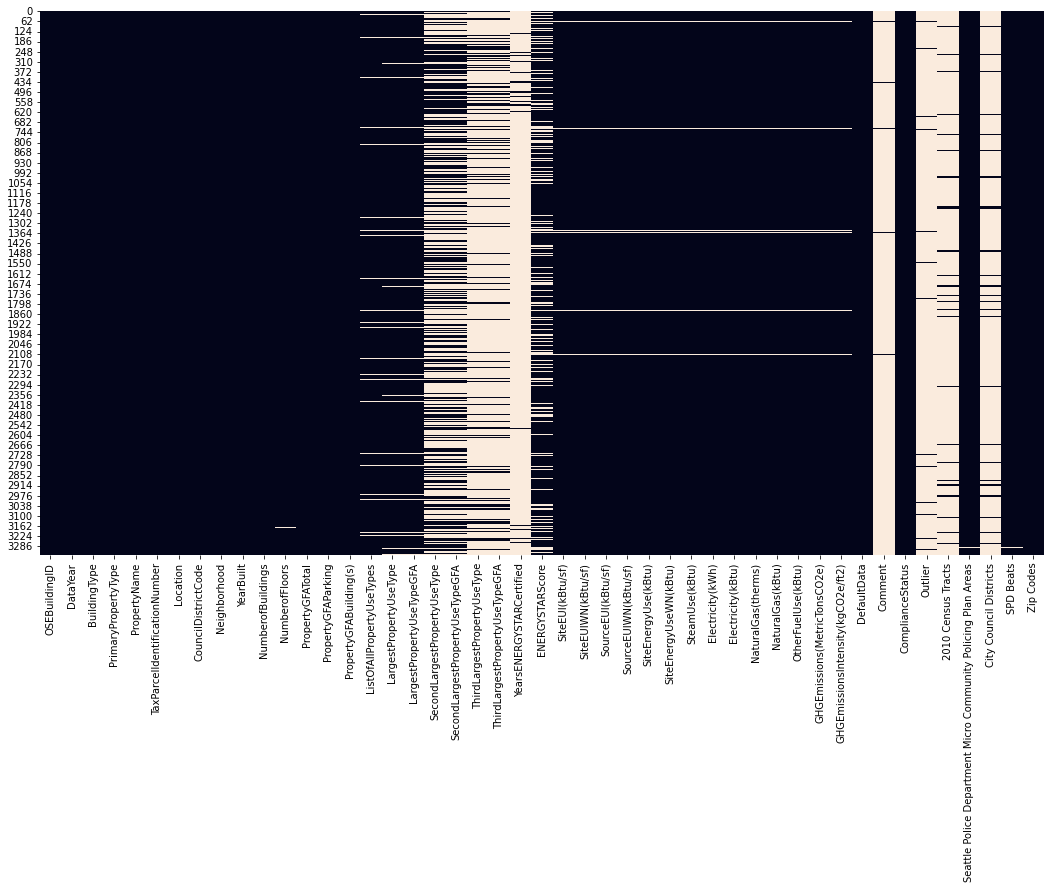

In [14]:
# View of missing values

# Specify size of heatmap
fig, ax = plt.subplots(figsize=(18, 10))

sns.heatmap(energy_2015.isna(), cbar=False);

In [15]:
# Keep only columns with less than 50% of missing values
energy_2015 = energy_2015[energy_2015.columns[energy_2015.isna().mean() < 0.5]]

In [16]:
# Checking all the data concern year 2015
energy_2015['DataYear'].value_counts().to_dict()

{2015: 3340}

In [17]:
# Shape of the dataset
print(f'energy_2015 dataset contains {energy_2015.shape[0]} records and {energy_2015.shape[1]} columns.')

energy_2015 dataset contains 3340 records and 38 columns.


- **9 columns have been dropped**

### 1st view of dataset 2016

In [18]:
# Read the dataset 2016
energy_2016 = pd.read_csv(
    "../input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv",
    sep=','
)

In [19]:
# Create a copy of the dataset 'energy_2016'
energy_2016_copy = energy_2016.copy()

In [20]:
# reduce_memory_usage of dataframe energy_2016
reduce_memory_usage(energy_2016)

Memory usage before: 1.16 MB
Memory usage now : 0.70 MB
Memory usage decreased by 40.2%


### Form analysis

In [21]:
# Print informations about dataset energy_2016
energy_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int32  
 1   DataYear                         3376 non-null   int16  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float32
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int8   
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [22]:
# Shape of the dataset
print(f'energy_2016 dataset contains {energy_2016.shape[0]} records and {energy_2016.shape[1]} columns.')

energy_2016 dataset contains 3376 records and 46 columns.


In [23]:
# Types of features
energy_2016.dtypes.value_counts()

object     15
float32    11
float16    11
int32       4
int16       2
int8        2
float64     1
dtype: int64

In [24]:
# Number of duplicated records in dataset 'energy_2016'
print('Number of duplicates in energy_2016 dataset:', 
      energy_2016.duplicated().sum())

Number of duplicates in energy_2016 dataset: 0


In [25]:
# Number of duplicated records in dataset 'energy_2016' for column 'OSEBuildingID'
energy_2016.duplicated('OSEBuildingID').sum()

0

In [26]:
# Missing values in the dataset 'energy_2016' ?
print(f'energy_2016 NaNs = {energy_2016.isna().sum().sum()}')
print('-'*20)
print(energy_2016.isna().mean().sort_values())

energy_2016 NaNs = 19952
--------------------
OSEBuildingID                      0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
YearBuilt                          0.000000
Longitude                          0.000000
Latitude                           0.000000
Neighborhood                       0.000000
DefaultData                        0.000000
CouncilDistrictCode                0.000000
ComplianceStatus                   0.000000
State                              0.000000
City                               0.000000
Address                            0.000000
PropertyName                       0.000000
PrimaryPropertyType                0.000000
BuildingType                       0.000000
DataYear                           0.000000
TaxParcelIdentificationNumber      0.000000
SiteEnergyUse(kBtu)                0.001481
SiteEnergyUseWN(kBtu)         

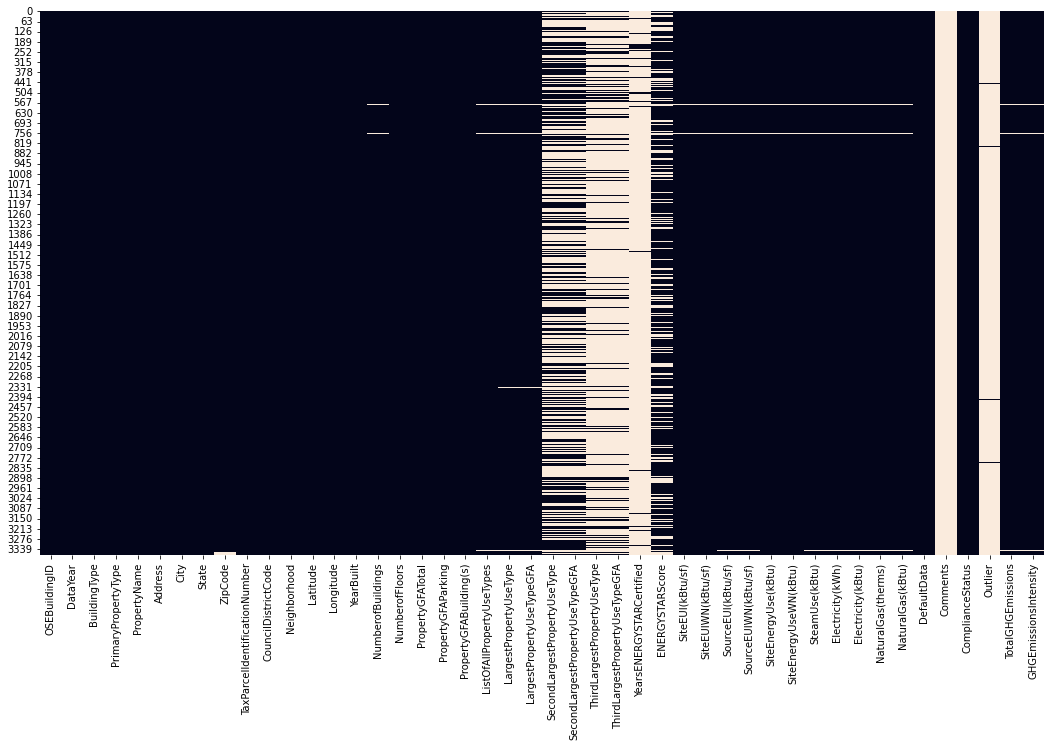

In [27]:
# View of missing values

# Specify size of heatmap
fig, ax = plt.subplots(figsize=(18, 10))

sns.heatmap(energy_2016.isna(), cbar=False);

In [28]:
# Keep only columns with less than 50% of missing values
energy_2016 = energy_2016[energy_2016.columns[energy_2016.isna().mean() < 0.5]]

In [29]:
# Checking all the data concern year 2016
energy_2016['DataYear'].value_counts().to_dict()

{2016: 3376}

In [30]:
# Shape of the dataset
print(f'energy_2016 dataset contains {energy_2016.shape[0]} records and {energy_2016.shape[1]} columns.')

energy_2016 dataset contains 3376 records and 39 columns.


- **7 columns have been dropped**

# Concatenate datasets 2015 & 2016  

The concatenation of the 2 data sets will allow machine learning models to be trained on a larger amount of data, in order to minimize overfitting in particular.

The first step is to identify:

- the variables common to the 2 datasets and bearing the same names

- the variables common to the 2 datasets and bearing different names

- variables present in one dataset but not in the other

In [31]:
# Column names in dataset 2015
columns_2015 = energy_2015.columns.tolist()

# Column names in dataset 2016
columns_2016 = energy_2016.columns.tolist()

In [32]:
# display the column names present in 2016 but not in 2015
col_2016_not_2015 = np.setdiff1d(
    columns_2016, 
    columns_2015, 
    assume_unique=True
)

col_2016_not_2015

array(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'], dtype='<U29')

In [33]:
# display the column names present in 2015 but not in 2016
col_2015_not_2016 = np.setdiff1d(
    columns_2015, 
    columns_2016, 
    assume_unique=True
)

col_2015_not_2016

array(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'SPD Beats', 'Zip Codes'], dtype='<U61')

- 'Location' of 2015 includes 'Address', 'City', 'State', 'ZipCode', 'Latitude' and 'Longitude' of 2016
 -> *We don't keep them because the location is already present in the categorical variables such as 'Neighborhood' and 'CouncilDistrictCode'*


- 'Zip Codes' of 2015 corresponds to 'ZipCode' of 2016 but is not kept for the reasons mentioned above.


- 'OtherFuelUse(kBtu)' from 2015 is missing from 2016
 -> *We do not keep it (moreover, almost only 0 for this variable)*


- 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)' of 2015 correspond to 'TotalGHGEmissions', 'GHGEmissionsIntensity' of 2016
 -> *We change the name of the variables from 2015 to that of 2016 to concatenate the 2 dataframes*


- 'Comment' of 2015 corresponds to 'Comments' of 2016
 -> *We change the name of the variable from 2015 to that of 2016 to concatenate the 2 dataframes*


- 'Seattle Police Department Micro Community Policing Plan Areas' and 'SPD Beats' of 2015 are missing from 2016
 -> *We do not keep these variables which do not seem essential to the business problem*

### common features with different names in 2015 and 2016

In [34]:
# Rename column of 2015 with column names of 2016
energy_2015 = energy_2015.rename(columns={
    'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
    'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
    'Comment' : 'Comments'
})

In [35]:
# Column names in dataset 2015 after renaming
columns_2015 = energy_2015.columns.tolist()

### Features from 2016 absent from 2015 and from 2015 absent from 2016 after renaming

In [36]:
# variable names present in 2016 but not in 2015 after renaming
different_col_2016 = np.setdiff1d(
    columns_2016,
    columns_2015, 
    assume_unique=True
)

different_col_2016

array(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'],
      dtype='<U29')

In [37]:
# variable names present in 2015 but not in 2016 after renaming
different_col_2015 = np.setdiff1d(
    columns_2015, 
    columns_2016, 
    assume_unique=True
)
different_col_2015

array(['Location', 'OtherFuelUse(kBtu)',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'SPD Beats', 'Zip Codes'], dtype='<U61')

### Creation of the list of variables to keep and concatenation of the 2 dataframes

In [38]:
# list containing only identical variable names
# and therefore to be kept initially during concatenation
same_col = [e for e in columns_2016 if
            ((e not in different_col_2016) & (e not in different_col_2015))]

In [39]:
# Concatenate the 2 dataframes keeping only the common features
energy = pd.concat(
    [energy_2015, energy_2016], 
    join="inner", 
    ignore_index=True
)

In [40]:
# check that all the data has been concatenated
energy['DataYear'].value_counts().to_dict()

{2016: 3376, 2015: 3340}

# Selection of non residential estates


-> The study concerns **non residential estates**.

-> The 1st step of cleaning is therefore to select **only** the **non residential estates**.

### Selection via categorical feature "BuildingType"?

In [41]:
# list of BuildingType in order to make a first filter
# for the mission: we only want non residential buildings
BuildingType = energy["BuildingType"].unique().tolist()
BuildingType

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

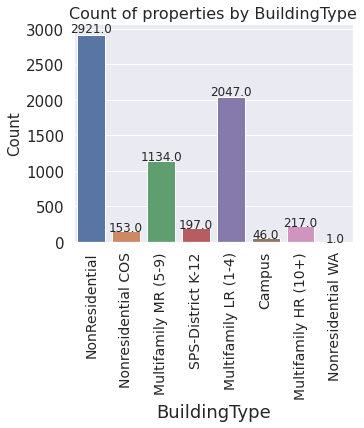

In [42]:
# Countplot of the number of estates by BuildingType
plt.figure(figsize=(5,4))
sns.set_theme(style="darkgrid")

g = sns.countplot(x="BuildingType", data=energy)

plt.yticks(fontsize=15)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("BuildingType", size=18)
plt.ylabel("Count", size=15)
plt.title("Count of properties by BuildingType", fontsize=16)

show_values(g);

- The categories to be eliminated would be "Multifamily MR (5-9)", "Multifamily LR (1-4)" and "Multifamily HR (10+)"

### Selection via categorical feature "PrimaryPropertyType"?

In [43]:
# list of Primary PropertyType in order to find matches
# with BuildingTypes
PrimaryPropertyType = energy["PrimaryPropertyType"].unique().tolist()
PrimaryPropertyType

['Hotel',
 'Other',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small- and Mid-Sized Office',
 'Self-Storage Facility\n',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Low-Rise Multifamily',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Residence Hall/Dormitory',
 'Non-Refrigerated Warehouse',
 'Distribution Center\n',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Self-Storage Facility',
 'Refrigerated Warehouse',
 'High-Rise Multifamily',
 'Restaurant\n',
 'Restaurant',
 'University',
 'Warehouse',
 'Residence Hall',
 'Supermarket / Grocery Store',
 'Office']

In [44]:
# We remove the '\n' from the concerned PrimaryPropertyType
# and we group identical categories with different names
    
# Save the position index of the "PrimaryPropertyType" column
index_PrimaryPropertyType = energy.columns.get_loc("PrimaryPropertyType")
for i in energy.index:   
    if energy.iloc[i,index_PrimaryPropertyType] == 'Self-Storage Facility\n':
        energy.iloc[i,index_PrimaryPropertyType] = 'Self-Storage Facility'
    elif energy.iloc[i,index_PrimaryPropertyType] == 'Distribution Center\n':
        energy.iloc[i,index_PrimaryPropertyType] = 'Distribution Center'
    elif energy.iloc[i,index_PrimaryPropertyType] == 'Restaurant\n':
        energy.iloc[i,index_PrimaryPropertyType] = 'Restaurant'
    elif energy.iloc[i,index_PrimaryPropertyType] == 'Supermarket / Grocery Store':
        energy.iloc[i,index_PrimaryPropertyType] = 'Supermarket/Grocery Store'
    elif energy.iloc[i,index_PrimaryPropertyType] == 'Warehouse':
        energy.iloc[i,index_PrimaryPropertyType] = 'Non-Refrigerated Warehouse'
    elif energy.iloc[i,index_PrimaryPropertyType] == 'University':
        energy.iloc[i,index_PrimaryPropertyType] = 'College/University'
    else:
        continue

In [45]:
# check that the loop has corrected these input errors
PrimaryPropertyType = energy["PrimaryPropertyType"].unique().tolist()
PrimaryPropertyType

['Hotel',
 'Other',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small- and Mid-Sized Office',
 'Self-Storage Facility',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Low-Rise Multifamily',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Residence Hall/Dormitory',
 'Non-Refrigerated Warehouse',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'High-Rise Multifamily',
 'Restaurant',
 'Residence Hall',
 'Office']

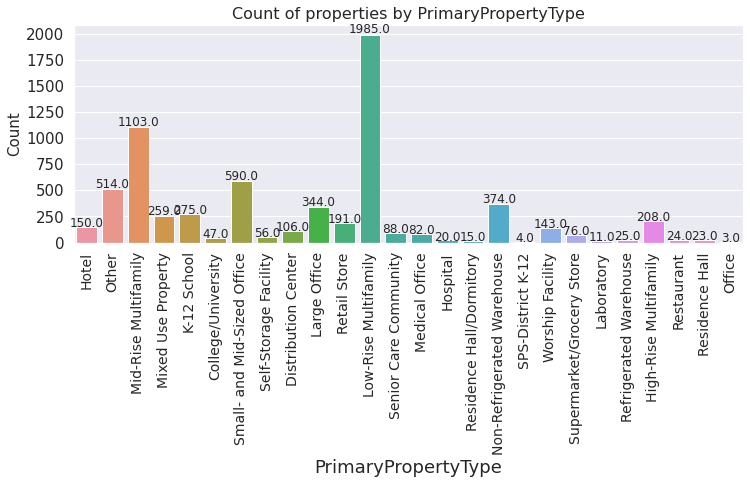

In [46]:
# Countplot of estates by PrimaryPropertyType
plt.figure(figsize=(12,4))
sns.set_theme(style="darkgrid")

g = sns.countplot(x="PrimaryPropertyType", data=energy)

plt.yticks(fontsize=15)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("PrimaryPropertyType", size=18)
plt.ylabel("Count", size=15)
plt.title("Count of properties by PrimaryPropertyType", fontsize=16)

show_values(g);

In [47]:
# Creating a dictionary that groups PrimaryPropertyType groups by BuildingType group
PrimaryPropertyType_by_BuildingType = {
    Building + "_PrimaryPropertyType": (
        energy.loc[energy["BuildingType"] == Building]["PrimaryPropertyType"].unique().tolist())
    for Building in BuildingType
    }

In [48]:
PrimaryPropertyType_by_BuildingType

{'NonResidential_PrimaryPropertyType': ['Hotel',
  'Other',
  'Mixed Use Property',
  'College/University',
  'Small- and Mid-Sized Office',
  'Self-Storage Facility',
  'Distribution Center',
  'K-12 School',
  'Large Office',
  'Retail Store',
  'Senior Care Community',
  'Medical Office',
  'Hospital',
  'Residence Hall/Dormitory',
  'Non-Refrigerated Warehouse',
  'Worship Facility',
  'Supermarket/Grocery Store',
  'Laboratory',
  'Refrigerated Warehouse',
  'Restaurant',
  'Low-Rise Multifamily',
  'Residence Hall'],
 'Nonresidential COS_PrimaryPropertyType': ['Other',
  'Non-Refrigerated Warehouse',
  'Small- and Mid-Sized Office',
  'Distribution Center',
  'Large Office',
  'Mixed Use Property',
  'Medical Office',
  'Office'],
 'Multifamily MR (5-9)_PrimaryPropertyType': ['Mid-Rise Multifamily',
  'Mixed Use Property',
  'Senior Care Community',
  'Other',
  'Residence Hall'],
 'SPS-District K-12_PrimaryPropertyType': ['K-12 School',
  'SPS-District K-12',
  'Other'],
 'Multi

### Attention :

- We can observe that **some PrimaryPropertyType are found in several BuildingType**

- In addition, we have PrimaryPropertyType **"other"** and **"Mixed Use Property"** which **could be residential**.

- Finally, **"Low-Rise Multifamily"**, **"Senior Care Community"** and **"Residence Hall/Dormitory"** are included in NonResidential BuildingTypes while they are **clearly residential PrimaryPropertyTypes **

-> We decide to use the 'PrimaryPropertyType' categorical feature to select non-residential properties

### Creation of the "non-residential estates" dataframe via the "PrimaryPropertyType" categorical variable

In [49]:
# Create a list of non residential PrimaryPropertyTypes
Non_residential = [
    'Hotel', 'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
    'Self-Storage Facility', 'Distribution Center', 'Large Office', 'Retail Store',
    'Medical Office', 'Hospital', 'Non-Refrigerated Warehouse', 'SPS-District K-12',
    'Worship Facility', 'Supermarket/Grocery Store', 'Laboratory',
    'Refrigerated Warehouse', 'Restaurant', 'University', 'Warehouse',
    'Supermarket / Grocery Store', 'Office'
]

In [50]:
# Create a dataframe with only non residential PrimaryPropertyTypes
energy = energy.loc[energy['PrimaryPropertyType'].isin(Non_residential)]

### Cleaning NaN for targets 'SiteEnergyUse' & 'GHGEmissions'

In [51]:
# Missing values
energy.isna().mean().sort_values()

OSEBuildingID                    0.000000
PropertyGFABuilding(s)           0.000000
PropertyGFAParking               0.000000
PropertyGFATotal                 0.000000
YearBuilt                        0.000000
Neighborhood                     0.000000
ComplianceStatus                 0.000000
TaxParcelIdentificationNumber    0.000000
PropertyName                     0.000000
CouncilDistrictCode              0.000000
DataYear                         0.000000
PrimaryPropertyType              0.000000
BuildingType                     0.000000
DefaultData                      0.000397
NumberofBuildings                0.000397
NumberofFloors                   0.001190
GHGEmissionsIntensity            0.003173
TotalGHGEmissions                0.003173
Electricity(kWh)                 0.003173
NaturalGas(kBtu)                 0.003173
SiteEUI(kBtu/sf)                 0.003173
SourceEUI(kBtu/sf)               0.003173
SourceEUIWN(kBtu/sf)             0.003173
SiteEnergyUse(kBtu)              0

In [52]:
# Removal of missing values for the targets necessary for the study:
# SiteEnergyUse, GHGEmissions
targets = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

energy = energy.dropna(subset=targets)

In [53]:
# Missing values after cleaning
energy.isna().mean().sort_values()

OSEBuildingID                    0.000000
GHGEmissionsIntensity            0.000000
TotalGHGEmissions                0.000000
NaturalGas(kBtu)                 0.000000
NaturalGas(therms)               0.000000
Electricity(kBtu)                0.000000
Electricity(kWh)                 0.000000
SteamUse(kBtu)                   0.000000
SiteEnergyUse(kBtu)              0.000000
SourceEUIWN(kBtu/sf)             0.000000
SourceEUI(kBtu/sf)               0.000000
SiteEUI(kBtu/sf)                 0.000000
DefaultData                      0.000000
ComplianceStatus                 0.000000
DataYear                         0.000000
PropertyGFAParking               0.000000
BuildingType                     0.000000
PropertyGFATotal                 0.000000
NumberofBuildings                0.000000
YearBuilt                        0.000000
PropertyGFABuilding(s)           0.000000
Neighborhood                     0.000000
CouncilDistrictCode              0.000000
TaxParcelIdentificationNumber    0

# Exploratory analysis:

Exploratory data analysis **after selection of non-residential estates**:

-> potential features\
-> targets:\
     * SiteEnergyUse(ktBu)\
     * TotalGHGEmissions

## Categorical features

In [54]:
# List of categorical features
cat_columns = [
    'BuildingType', 'PrimaryPropertyType',
    'CouncilDistrictCode','Neighborhood', 'YearBuilt', 
    'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseType'
]

In [55]:
# Upper Neighborhood categories
energy['Neighborhood'] = energy['Neighborhood'].str.upper()

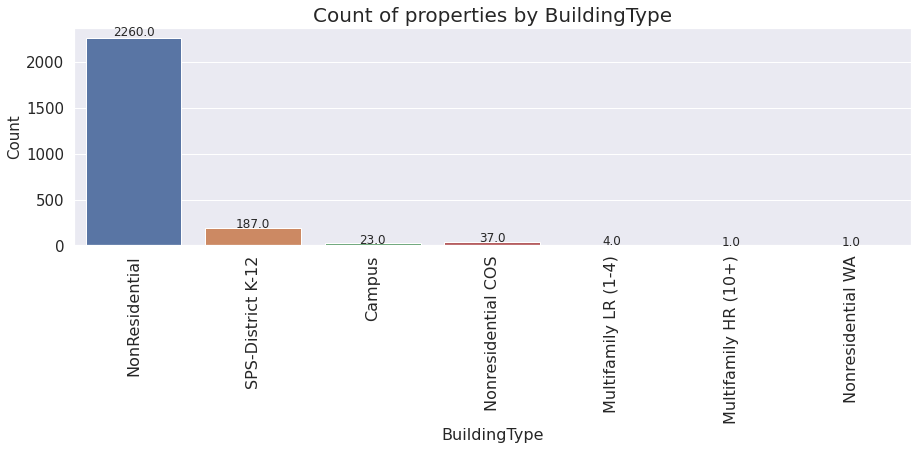

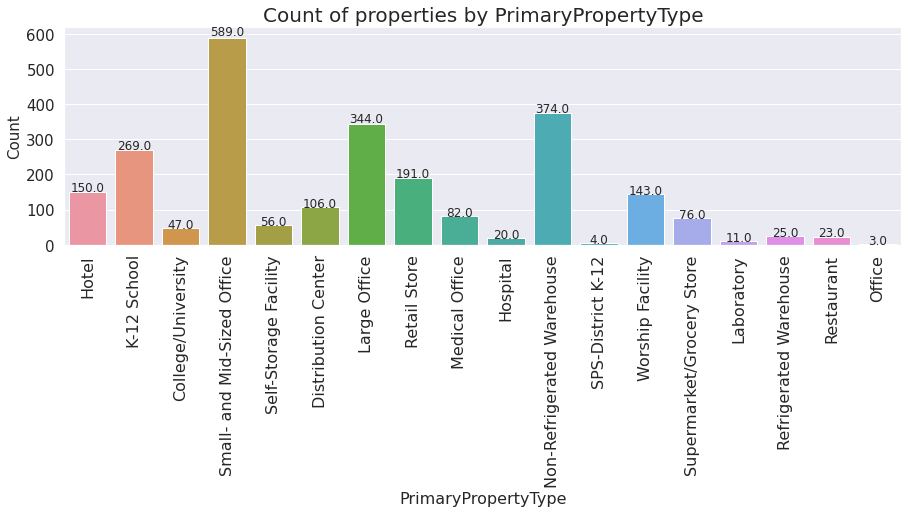

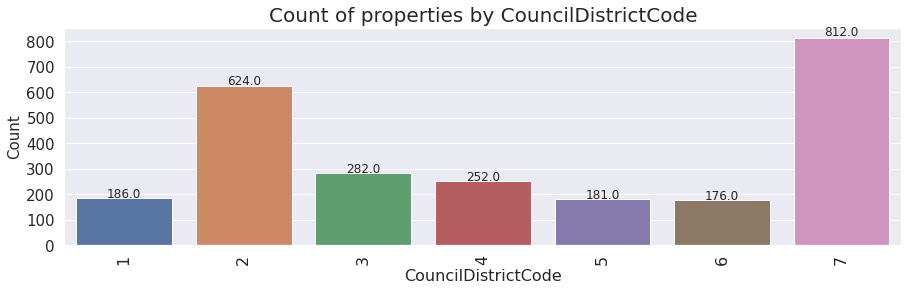

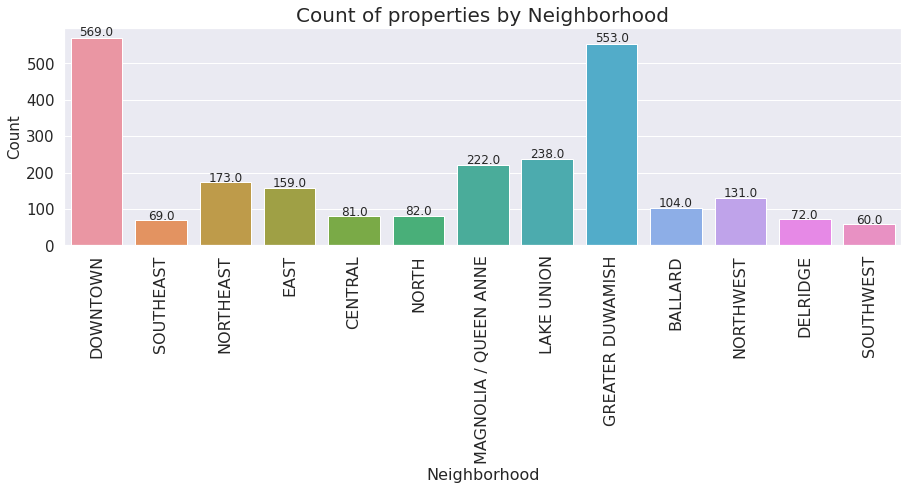

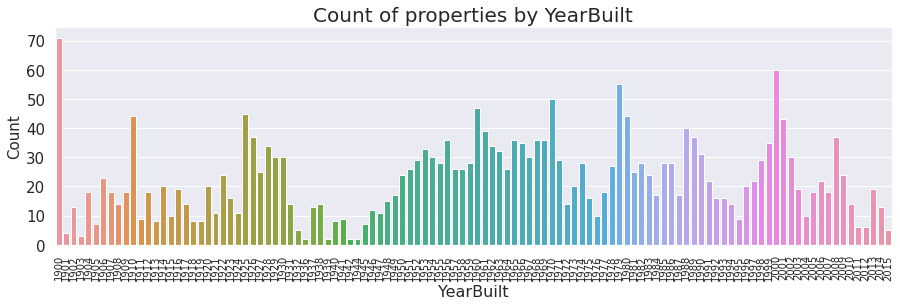

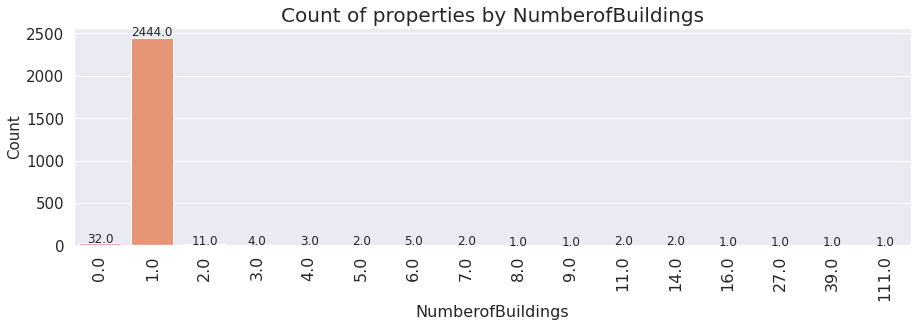

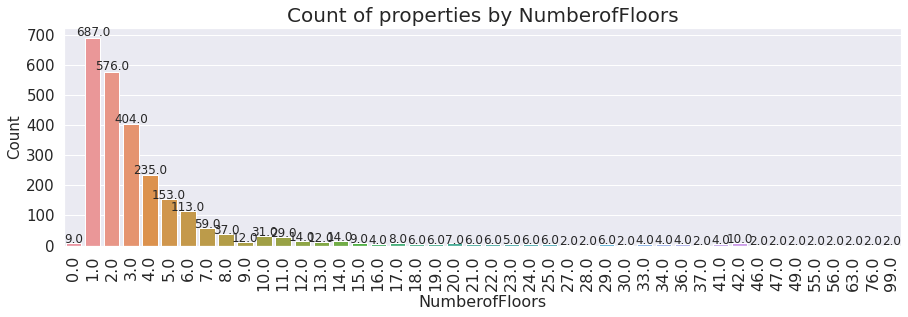

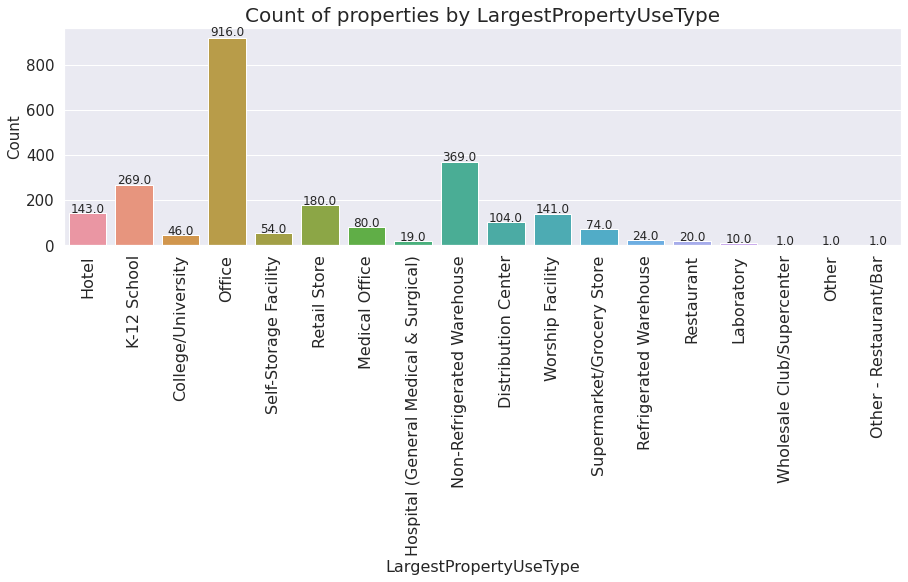

In [56]:
# Display countplots of estates by categorical features
for col in cat_columns:
    display_countplot(df=energy, x=col)

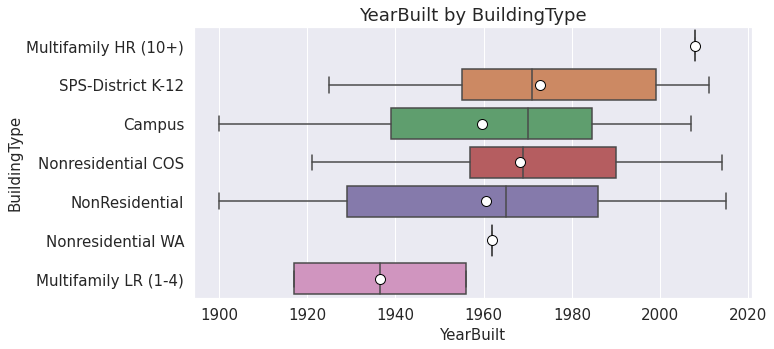

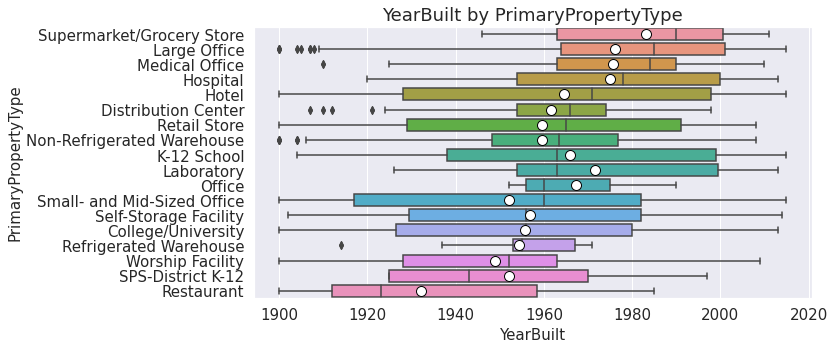

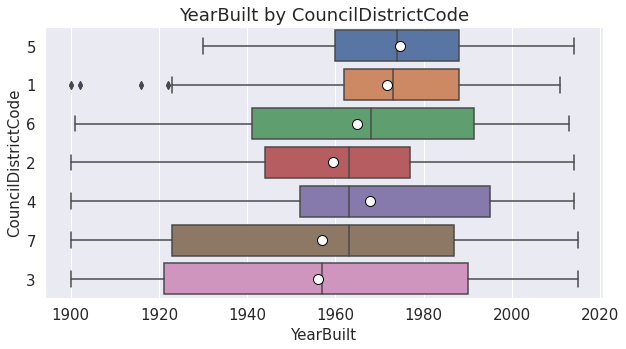

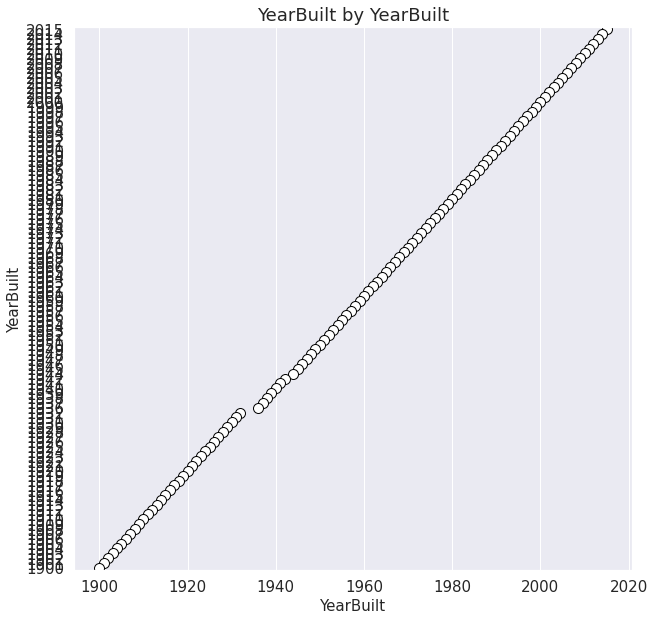

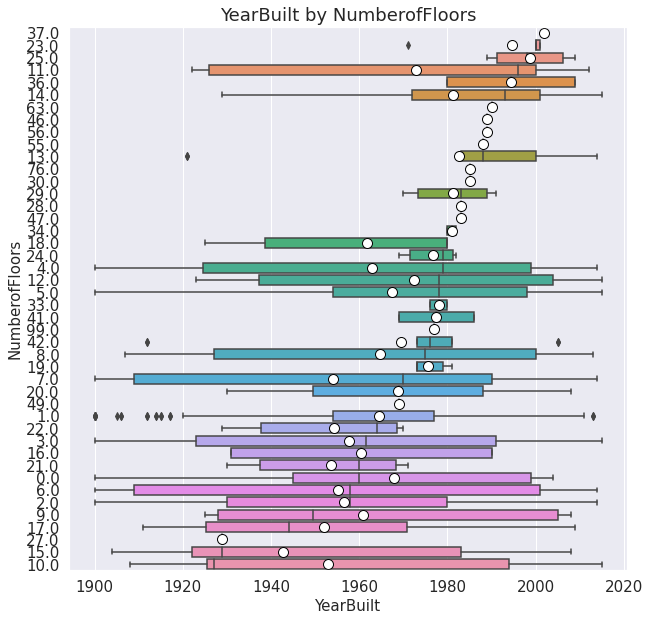

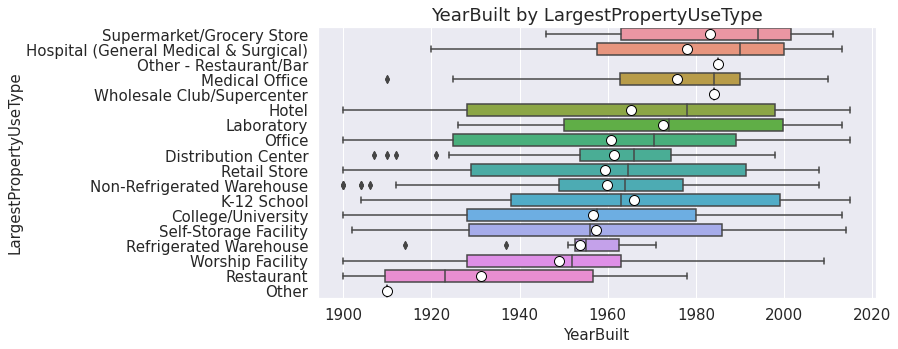

In [57]:
# Boxplot YearBuilt by categorical features
for col in cat_columns:
    display_boxplot(df=energy, x='YearBuilt', y=col)

## Quantitative features

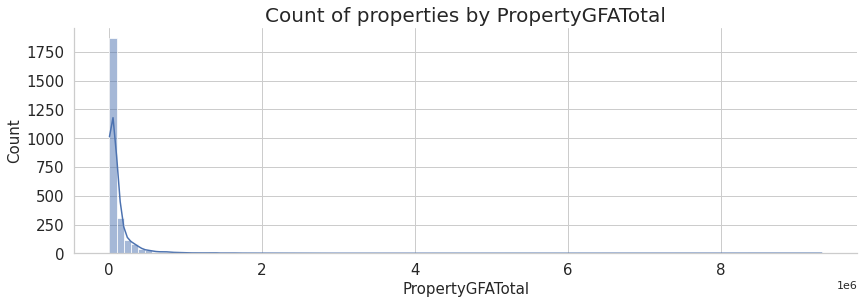

In [58]:
# Distribution of the number of properties by PropertyGFATotal
sns.set_theme(style="whitegrid")
sns.displot(energy, x="PropertyGFATotal", 
            bins=100, kde=True, height=4, aspect=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("PropertyGFATotal", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of properties by PropertyGFATotal", fontsize=20);

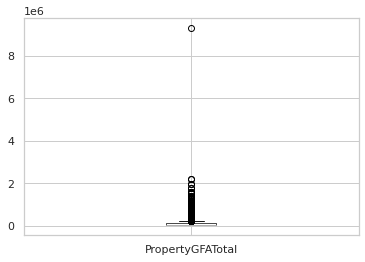

In [59]:
# Boxplot of PropertyGFATotal
energy.boxplot(column=['PropertyGFATotal'])
plt.show()

In [60]:
# Print statistical values for PropertyGFATotal
energy[['PropertyGFATotal']].describe()

PropertyGFATotal
count      2.513000e+03
mean       1.202815e+05
std        2.708348e+05
min        1.229400e+04
25%        3.056200e+04
50%        5.121800e+04
75%        1.105240e+05
max        9.320156e+06

In [61]:
# Create feature 'log10PropertyGFATotal'
energy['log10PropertyGFATotal'] = np.log10(energy['PropertyGFATotal'])

In [62]:
# Distribution of the number of properties by log10PropertyGFATotal
sns.set_theme(style="whitegrid")
sns.displot(energy, x="log10PropertyGFATotal", 
            bins=100, kde=True, height=4, aspect=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("log10PropertyGFATotal", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of properties by log10PropertyGFATotal", fontsize=20);

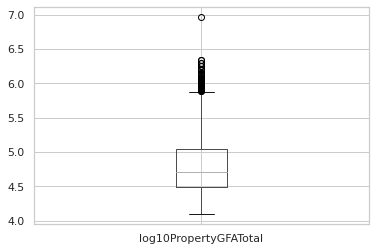

In [63]:
# Boxplot of log10PropertyGFATotal
energy.boxplot(column=['log10PropertyGFATotal'])
plt.show()

In [64]:
# Boxplot PropertyGFATotal by Neighborhood
display_boxplot(df=energy, x='PropertyGFATotal', y='Neighborhood', showfliers=False)

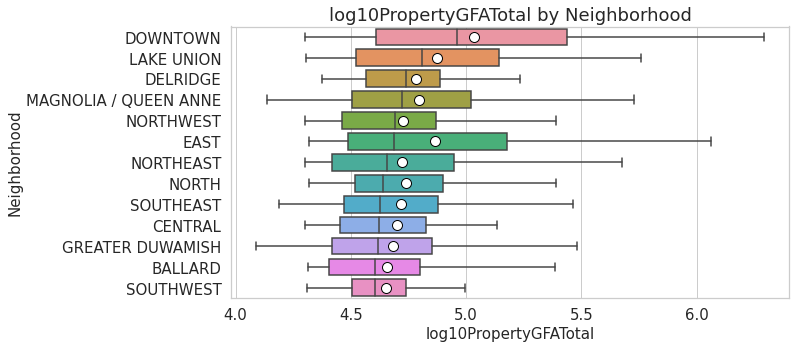

In [65]:
# Boxplot PropertyGFATotal by Neighborhood
display_boxplot(df=energy, x='log10PropertyGFATotal', y='Neighborhood', showfliers=False)

### Feature ENERGYSTARScore

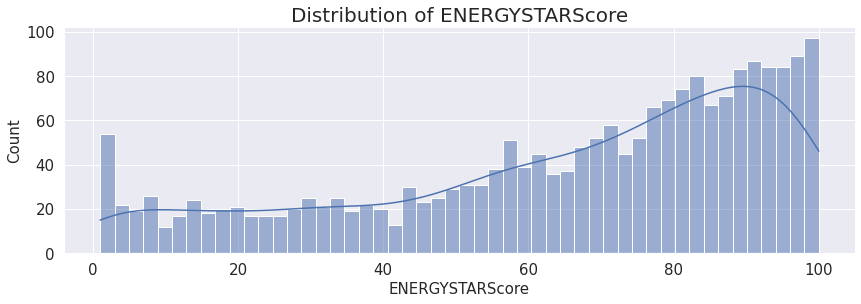

In [66]:
# Distribution of ENERGYSTARScore
sns.set_theme()
sns.displot(energy, x="ENERGYSTARScore", 
            bins=50, kde=True, height=4, aspect=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("ENERGYSTARScore", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of ENERGYSTARScore", fontsize=20);

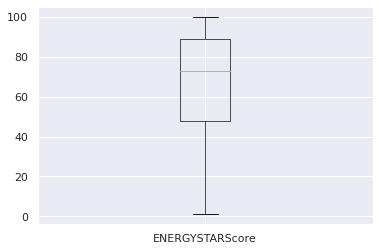

In [67]:
# Boxplot of energystarscore
energy.boxplot(column=['ENERGYSTARScore'])
plt.show()

In [68]:
# Print statistical values of ENERGYSTARScore
energy[['ENERGYSTARScore']].describe()

ENERGYSTARScore
count        2070.0000
mean               inf
std            28.3125
min             1.0000
25%            48.0000
50%            73.0000
75%            89.0000
max           100.0000

In [69]:
# Boxplot of ENERGYSTARScore by categorical columns
columns = ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood']

for col in columns:
    display_boxplot(df=energy,
                    x='ENERGYSTARScore',
                    y=col,
                    showfliers=True)

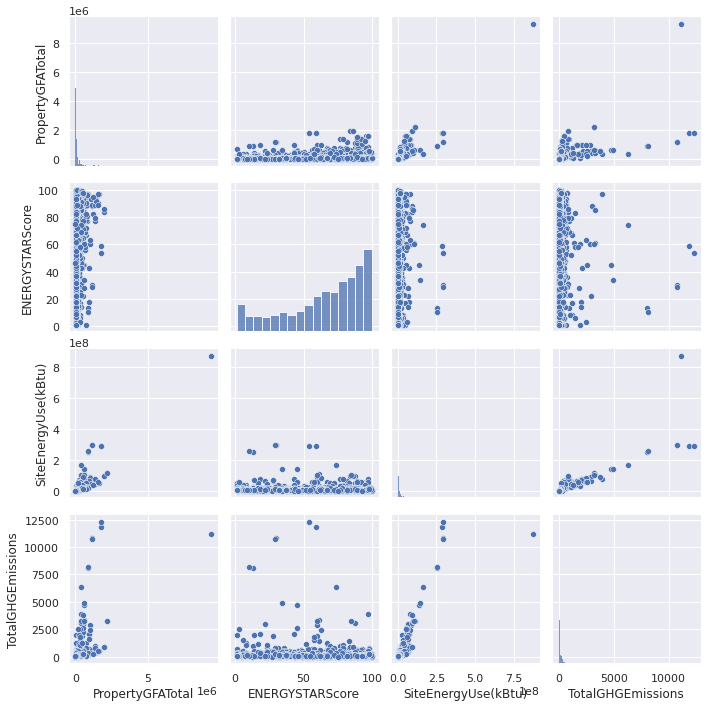

In [70]:
# Pairplot for quantitative features
quant_col = ['PropertyGFATotal', 'ENERGYSTARScore', 
             'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

sns.pairplot(energy[quant_col]);

### target "SiteEnergyUse"

In [71]:
# Distribution of SiteEnergyUse(kBtu)
sns.set_theme()
sns.displot(energy, x="SiteEnergyUse(kBtu)", 
            bins=1000, kde=True, height=6, aspect=2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("SiteEnergyUse(kBtu)", size=15)
plt.ylabel("Count", size=15)
plt.xlim(0, 0.5e8)
plt.title("Distribution of SiteEnergyUse(kBtu)", fontsize=20);

In [72]:
# Statistical values of SiteEnergyUse(kBtu)
energy[['SiteEnergyUse(kBtu)']].describe()

SiteEnergyUse(kBtu)
count               2513.0
mean             7560380.0
std             25147726.0
min                    0.0
25%              1160989.0
50%              2371304.5
75%              6668456.0
max            873923712.0

In [73]:
# Delete values 'SiteEnergyUse(kBtu)' == 0
energy = energy.loc[energy['SiteEnergyUse(kBtu)'] > 0]

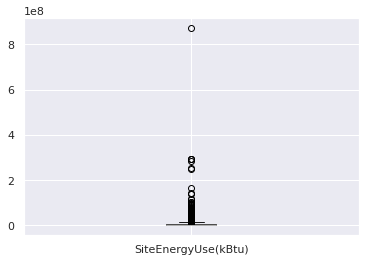

In [74]:
# Boxplot of SiteEnergyUse(kBtu)
energy.boxplot(column=['SiteEnergyUse(kBtu)'])
plt.show()

In [75]:
cat_columns

['BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'LargestPropertyUseType']

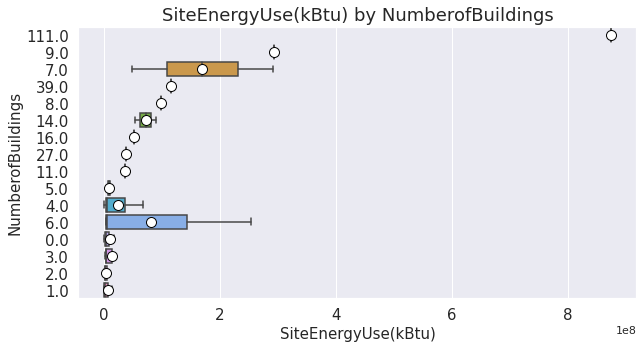

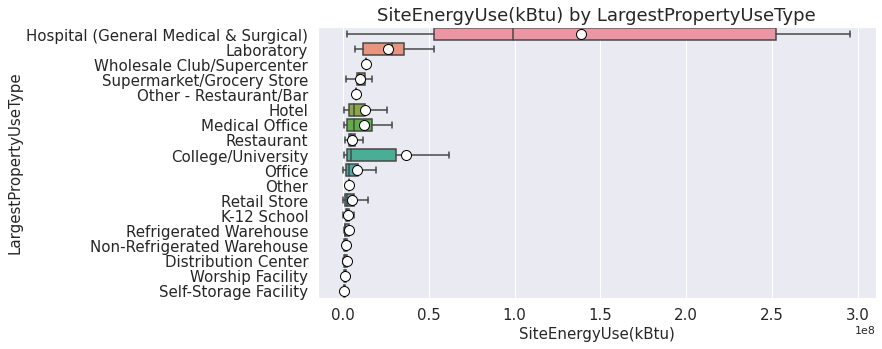

In [76]:
# Boxplot SiteEnergyUse(kBtu) by categorical features
cat_columns = [
    'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
    'NumberofBuildings', 'LargestPropertyUseType']

for col in cat_columns:
    display_boxplot(
        df=energy, 
        x='SiteEnergyUse(kBtu)', 
        y=col, 
        showfliers=False
    )

In [77]:
# Create feature 'log10SiteEnergyUse'
energy['log10SiteEnergyUse'] = np.log10(energy['SiteEnergyUse(kBtu)'])

In [78]:
# Distribution of log10SiteEnergyUse
sns.set_theme()
sns.displot(energy, x="log10SiteEnergyUse", 
            bins=50, kde=True, height=4, aspect=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("log10SiteEnergyUse", size=15)
plt.ylabel("Count", size=15)
plt.title("Distibution of log10SiteEnergyUse", fontsize=20);

### Creation of new energy variables: proportions of the different energies used (to avoid data leakage)

In [79]:
# Observe features to transform
energy[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].describe()

SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)
count    2.497000e+03             2497.0      2.497000e+03
mean     5.385136e+05          5407887.0      1.582478e+06
std      5.911269e+06         17241298.0      5.982866e+06
min      0.000000e+00          -115417.0      0.000000e+00
25%      0.000000e+00           702564.0      0.000000e+00
50%      0.000000e+00          1593253.0      4.118190e+05
75%      0.000000e+00          4789948.0      1.257900e+06
max      1.349435e+08        657074368.0      1.381912e+08

In [80]:
# Delete negative and null values for feature "Electricity(kBtu)"
energy = energy.loc[energy['Electricity(kBtu)'] > 0]

In [81]:
# Create new features: proportions of energy sources used
energy['total_energy'] = (
    energy['SteamUse(kBtu)'] 
    + energy['Electricity(kBtu)'] 
    + energy['NaturalGas(kBtu)']
)

energy['prop_electricity'] = (
    energy['Electricity(kBtu)'] / energy['total_energy']
)

energy['prop_steam'] = (
    energy['SteamUse(kBtu)'] / energy['total_energy']
)

energy['prop_naturalgas'] = (
    energy['NaturalGas(kBtu)'] / energy['total_energy']
)

### Target "TotalGHGEmissions"

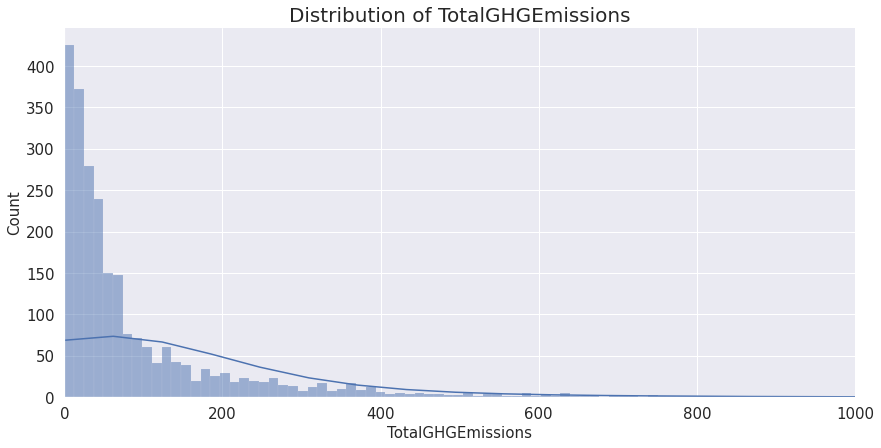

In [82]:
# Distribution of TotalGHGEmissions
sns.set_theme()
sns.displot(energy, x="TotalGHGEmissions", 
            bins=1000, kde=True, height=6, aspect=2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("TotalGHGEmissions", size=15)
plt.ylabel("Count", size=15)
plt.xlim(0, 1000)
plt.title("Distribution of TotalGHGEmissions", fontsize=20);

In [83]:
# Statistical values of TotalGHGEmissions
energy[['TotalGHGEmissions']].astype(float).describe()

TotalGHGEmissions
count        2494.000000
mean          163.265420
std           652.676317
min             0.080017
25%            18.304688
50%            46.234375
75%           124.656250
max         12304.000000

In [84]:
# Delete negative and null values for feature "TotalGHGEmissions"
energy = energy.loc[energy['TotalGHGEmissions'] > 0]

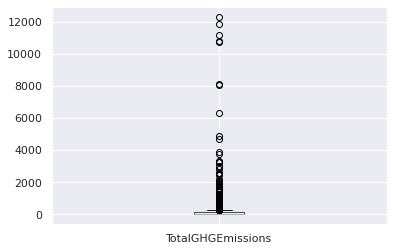

In [85]:
# Boxplot of TotalGHGEmissions
energy.boxplot(column=['TotalGHGEmissions'])
plt.show()

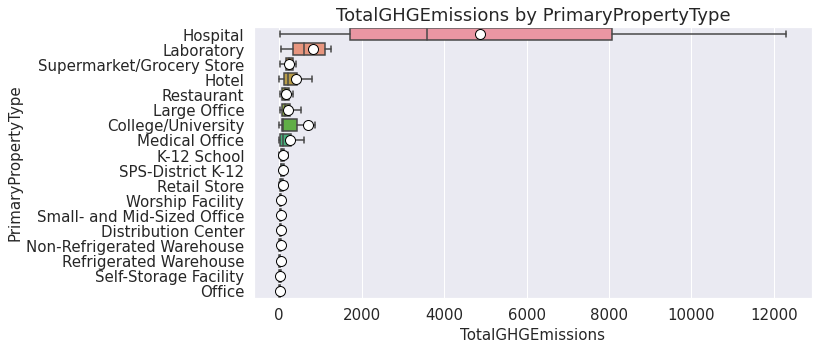

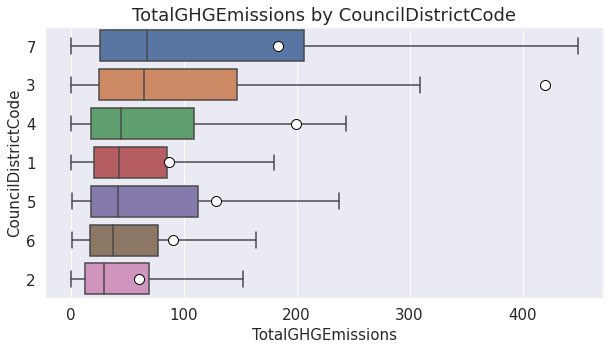

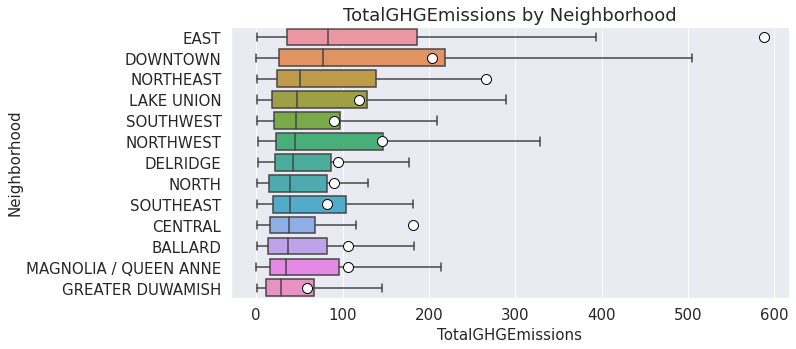

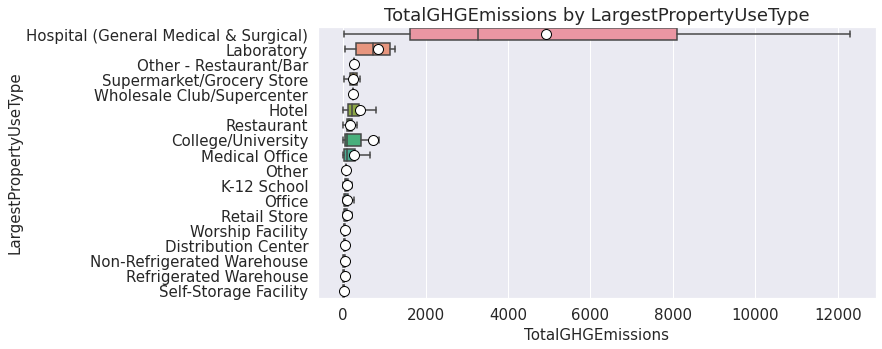

In [86]:
# Boxplot TotalGHGEmissions by categorical features
cat_columns = [
    'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
    'NumberofBuildings', 'LargestPropertyUseType'
]

for col in cat_columns:
    display_boxplot(
        df=energy, 
        x='TotalGHGEmissions', 
        y=col, 
        showfliers=False
    )

In [87]:
# Create feature'log10TotalGHGEmissions'
energy['log10GHGEmissions'] = np.log10(energy['TotalGHGEmissions'])

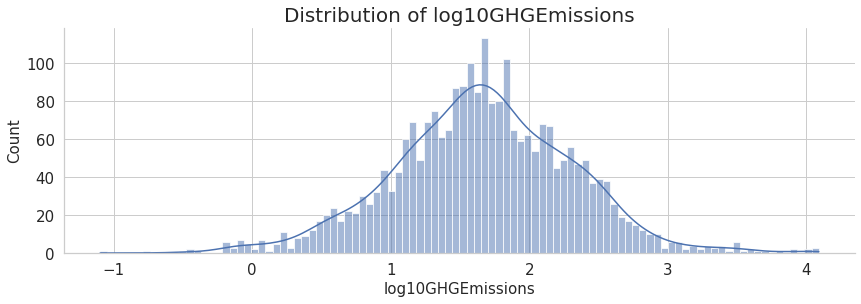

In [88]:
# Distribution of log10GHGEmissions
sns.set_theme(style="whitegrid")
sns.displot(energy, x="log10GHGEmissions", 
            bins=100, kde=True, height=4, aspect=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("log10GHGEmissions", size=15)
plt.ylabel("Count", size=15)
plt.title("Distribution of log10GHGEmissions", fontsize=20);

### Creation of a categorical variable on the nature of the energies used by property

In [89]:
# Reset index for the following loop
energy = energy.reset_index()

# Create the new column 'energy_type'
energy['energy_type'] = 0

# Save indices of columns 'energy_type', 'prop_electricity', 
# 'prop_naturalgas' et 'prop_steam'
index_energy = energy.columns.get_loc('energy_type')
index_elec = energy.columns.get_loc('prop_electricity')
index_gas = energy.columns.get_loc('prop_naturalgas')
index_steam = energy.columns.get_loc('prop_steam')

# Loop for each row of energy
for i in energy.index:
    
    # for each line, we record the location of each box "elec", "gas" and "steam"
    elec = energy.iloc[i, index_elec]
    gas = energy.iloc[i, index_gas]
    steam = energy.iloc[i, index_steam]
    
    # We assign a value to the variable value 'energy_type' 
    # according to the proportions of each energy
    if elec == 1:
        energy.iloc[i, index_energy] = 'electricity only'
    elif gas == 1: 
        energy.iloc[i, index_energy] = 'naturalgas only'
    elif steam == 1: 
        energy.iloc[i, index_energy] = 'steam only'
    elif ((elec > gas) & (steam == 0)):
        energy.iloc[i, index_energy] = 'electricity, naturalgas'
    elif ((elec > steam) & (gas == 0)):
        energy.iloc[i, index_energy] = 'electricity, steam'
    elif ((elec > gas > steam) & (steam != 0)):
        energy.iloc[i, index_energy] = 'electricity, naturalgas, steam'
    elif ((elec > steam > gas) & (gas != 0)):
        energy.iloc[i, index_energy] = 'electricity, steam, naturalgas'
    elif ((gas > elec) & (steam == 0)):
        energy.iloc[i, index_energy] = 'naturalgas, electricity'
    elif ((gas > steam) & (elec == 0)):
        energy.iloc[i, index_energy] = 'naturalgas, steam'
    elif ((gas > elec > steam) & (steam != 0)):
        energy.iloc[i, index_energy] = 'naturalgas, electricity, steam'
    elif ((gas > steam > elec) & (elec != 0)):
        energy.iloc[i, index_energy] = 'naturalgas, steam, electricity'
    elif ((steam > elec) & (gas == 0)):
        energy.iloc[i, index_energy] = 'steam, electricity'
    elif ((steam > gas) & (elec == 0)):
        energy.iloc[i, index_energy] = 'steam, naturalgas'
    elif ((steam > gas > elec) & (elec != 0)):
        energy.iloc[i, index_energy] = 'steam, naturalgas, electricity'
    elif ((steam > elec > gas) & (gas != 0)):
        energy.iloc[i, index_energy] = 'steam, electricity, naturalgas'

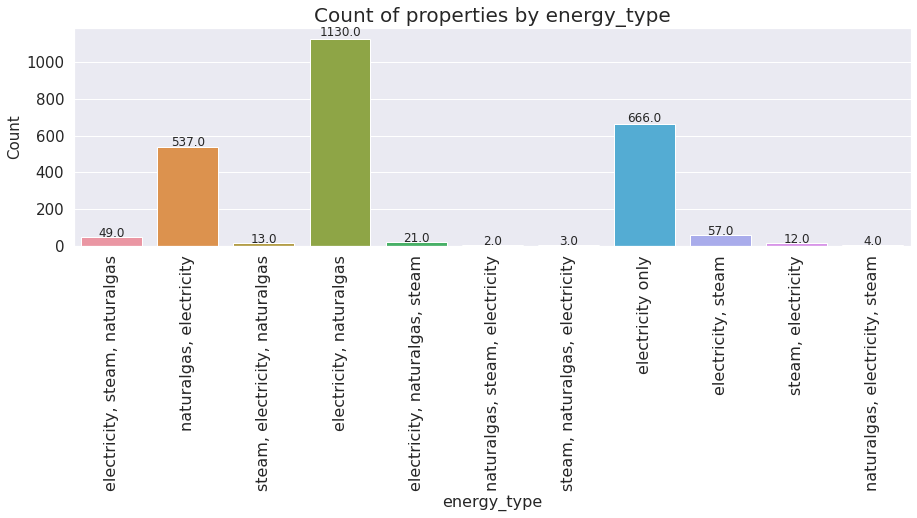

In [90]:
# Countplot of energy_type
display_countplot(df=energy, x='energy_type')

In [91]:
# Boxplot of SiteEnergyUse by energy_type
display_boxplot(df=energy, x='SiteEnergyUse(kBtu)', 
                y='energy_type', showfliers=False)

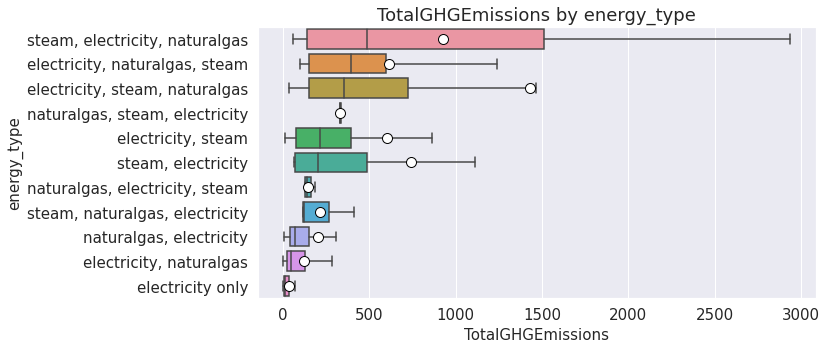

In [92]:
# Boxplot of 'TotalGHGEmissions' by energy_type
display_boxplot(df=energy, x='TotalGHGEmissions', 
                y='energy_type', showfliers=False)

## Analyses ANOVA : corrélations entre variable quantitatives et catégorielles

### SiteEnergyUse

In [93]:
energy['LargestPropertyUseType'].isna().sum()

61

In [94]:
# Delete missing values for "LargestPropertyUseType" 
energy = energy.dropna(subset=['LargestPropertyUseType'])

# to calculate eta squared between "LargestPropertyUseType" and "SiteEnergyUse(kBtu)"
target_columns = ["SiteEnergyUse(kBtu)", "log10SiteEnergyUse",
                  "TotalGHGEmissions", "log10GHGEmissions"]

cat_columns = ['LargestPropertyUseType']

# Calculate eta2 between target_columns and cat_columns
for cat in cat_columns:
    for target in target_columns:
        print(f"eta2 {cat}/{target} =",
              eta_squared(energy[cat],energy[target]))
    print('-----------------------------------')

eta2 LargestPropertyUseType/SiteEnergyUse(kBtu) = 0.25772856514753845
eta2 LargestPropertyUseType/log10SiteEnergyUse = 0.33343997673209436
eta2 LargestPropertyUseType/TotalGHGEmissions = inf
eta2 LargestPropertyUseType/log10GHGEmissions = 0.27942587671711905
-----------------------------------


In [95]:
target_columns = ["SiteEnergyUse(kBtu)", "log10SiteEnergyUse",
                  "TotalGHGEmissions", "log10GHGEmissions"]

cat_columns = ['PrimaryPropertyType', 'CouncilDistrictCode',
               'Neighborhood', 'energy_type']

# Calculate eta2 between target_columns and cat_columns
for cat in cat_columns:
    for target in target_columns:
        print(f"eta2 {cat}/{target} =",
              eta_squared(energy[cat],energy[target]))
    print('-----------------------------------')

eta2 PrimaryPropertyType/SiteEnergyUse(kBtu) = 0.2880126940467923
eta2 PrimaryPropertyType/log10SiteEnergyUse = 0.5175163794640194
eta2 PrimaryPropertyType/TotalGHGEmissions = inf
eta2 PrimaryPropertyType/log10GHGEmissions = 0.39149999020626003
-----------------------------------
eta2 CouncilDistrictCode/SiteEnergyUse(kBtu) = 0.02021979815611323
eta2 CouncilDistrictCode/log10SiteEnergyUse = 0.08267091902190157
eta2 CouncilDistrictCode/TotalGHGEmissions = inf
eta2 CouncilDistrictCode/log10GHGEmissions = 0.054137377186332
-----------------------------------
eta2 Neighborhood/SiteEnergyUse(kBtu) = 0.028176524364440906
eta2 Neighborhood/log10SiteEnergyUse = 0.11001396892324188
eta2 Neighborhood/TotalGHGEmissions = inf
eta2 Neighborhood/log10GHGEmissions = 0.07357450765404068
-----------------------------------
eta2 energy_type/SiteEnergyUse(kBtu) = 0.06929173898945794
eta2 energy_type/log10SiteEnergyUse = 0.11007728684643889
eta2 energy_type/TotalGHGEmissions = inf
eta2 energy_type/log10GH

**Site Energy Use**

- For location categorical variables: Neighborhood better than CounciDitrictCode


- For property type categorical variables: PrimaryPropertyType better than LargestPropertyUseType


- Switching to the SiteEnergyUse log improves the correlation


- the categorical variable created 'energy_type' is weakly correlated with SiteENergyUse: we will probably prefer the quantitative variables 'prop_electricity', 'prop_naturalgas' and 'prop_steam' for the prediction models


-> We will keep 2 categorical variables for the prediction models: PrimaryPropertyType and Neighborhood

**GHGEmissions**

- For location categorical variables: Neighborhood better than CounciDitrictCode


- For property type categorical variables: PrimaryPropertyType better than LargestPropertyUseType (by little)


- Switching to the log of TotalGHGEmissions improves the correlation for the categorical location variables and leads to a decrease in the correlation for the categorical property type variables


- the categorical variable created 'energy_type' is slightly correlated to TotalGHGEmissions: we will probably prefer the quantitative variables 'prop_electricity', 'prop_naturalgas' and 'prop_steam' for the prediction models

-> We will keep 2 categorical variables for the prediction models: PrimaryPropertyType and Neighborhood

## Chi-square test : Correlations between 2 categorical variables

### 'Neighborhood' et 'CouncilDistrictCode'

In [96]:
# Create a pivot table to observe the relationships 
# between 'Neighborhood' & 'CouncilDistrictCode'
pivot_table(
    df=energy, 
    x='Neighborhood', 
    y='CouncilDistrictCode'
)

CouncilDistrictCode      1    2    3    4    5    6    7  Total
Neighborhood                                                   
BALLARD                  0    0    0    0    0  100    0    100
CENTRAL                  0    0   73    0    0    0    0     73
DELRIDGE                71    0    0    0    0    0    0     71
DOWNTOWN                 0   65   17    0    0    0  468    550
EAST                     0    0  149    0    0    0    6    155
GREATER DUWAMISH        54  479    7    0    0    0    0    540
LAKE UNION               0    0   18   82    0   32   97    229
MAGNOLIA / QUEEN ANNE    0    0    0    0    0    0  215    215
NORTH                    0    0    0    2   77    0    0     79
NORTHEAST                0    0    0  161    8    0    0    169
NORTHWEST                0    0    0    0   92   37    0    129
SOUTHEAST                0   58    6    0    0    0    0     64
SOUTHWEST               59    0    0    0    0    0    0     59
Total                  184  602  270  245  177  169  786   2433

chi-2 = 10726.774784713598
degre(s) of freedom = 91
p_value = 0.0


-> Conclusion:

- the 'Neighborhood' and 'CouncilDistrictCode' variables are not independent according to the Pvalue.

- Moreover, according to the pivot table, the 2 variables are clearly correlated

### 'PrimaryPropertyType' et 'LargestPropertyUseType'

In [97]:
# Create a pivot table to observe the relationships 
# between 'PrimaryPropertyType' & 'LargestPropertyUseType'
pivot_table(
    df=energy, 
    x='PrimaryPropertyType', 
    y='LargestPropertyUseType'
)

LargestPropertyUseType       College/University  Distribution Center  \
PrimaryPropertyType                                                    
College/University                           46                    0   
Distribution Center                           0                  104   
Hospital                                      0                    0   
Hotel                                         0                    0   
K-12 School                                   0                    0   
Laboratory                                    0                    0   
Large Office                                  0                    0   
Medical Office                                0                    0   
Non-Refrigerated Warehouse                    0                    0   
Office                                        0                    0   
Refrigerated Warehouse                        0                    0   
Restaurant                                    0                    0   
Retail Store                                  0                    0   
Self-Storage Facility                         0                    0   
Small- and Mid-Sized Office                   0                    0   
Supermarket/Grocery Store                     0                    0   
Worship Facility                              0                    0   
Total                                        46                  104   

LargestPropertyUseType       Hospital (General Medical & Surgical)  Hotel  \
PrimaryPropertyType                                                         
College/University                                               0      0   
Distribution Center                                              0      0   
Hospital                                                        19      0   
Hotel                                                            0    143   
K-12 School                                                      0      0   
Laboratory                                                       0      0   
Large Office                                                     0      0   
Medical Office                                                   0      0   
Non-Refrigerated Warehouse                                       0      0   
Office                                                           0      0   
Refrigerated Warehouse                                           0      0   
Restaurant                                                       0      0   
Retail Store                                                     0      0   
Self-Storage Facility                                            0      0   
Small- and Mid-Sized Office                                      0      0   
Supermarket/Grocery Store                                        0      0   
Worship Facility                                                 0      0   
Total                                                           19    143   

LargestPropertyUseType       K-12 School  Laboratory  Medical Office  \
PrimaryPropertyType                                                    
College/University                     0           0               0   
Distribution Center                    0           0               0   
Hospital                               0           0               0   
Hotel                                  0           0               0   
K-12 School                          255           0               0   
Laboratory                             0          10               0   
Large Office                           0           0               0   
Medical Office                         0           0              80   
Non-Refrigerated Warehouse             0           0               0   
Office                                 0           0               0   
Refrigerated Warehouse                 0           0               0   
Restaurant                             0           0               0   
Retail Sto

chi-2 = 34062.0
degre(s) of freedom = 306
p_value = 0.0


Using 'PrimaryPropertyType' rather than 'LargestPropertyUseType' as a feature is more relevant because:
- better correlated with SiteEnergyUse and TotalGHGEmissions
- 1 single category with a small staff: 'office' with 3 individuals (to be deleted because it could cause a problem during the train_test_split?)

### 'PrimaryPropertyType' et 'Neighborhood'

In [98]:
# Create a pivot table to observe the relationships 
# between 'Neighborhood' & 'PrimaryPropertyType'
pivot_table(
    df=energy, 
    x='Neighborhood', 
    y='PrimaryPropertyType'
)

PrimaryPropertyType    College/University  Distribution Center  Hospital  \
Neighborhood                                                               
BALLARD                                 0                    2         2   
CENTRAL                                 6                    0         2   
DELRIDGE                                2                   10         0   
DOWNTOWN                                8                    0         0   
EAST                                   12                    0         5   
GREATER DUWAMISH                        2                   82         0   
LAKE UNION                              2                    4         2   
MAGNOLIA / QUEEN ANNE                   6                    6         0   
NORTH                                   0                    0         0   
NORTHEAST                               6                    0         4   
NORTHWEST                               2                    0         2   
SOUTHEAST                               0                    0         0   
SOUTHWEST                               0                    0         2   
Total                                  46                  104        19   

PrimaryPropertyType    Hotel  K-12 School  Laboratory  Large Office  \
Neighborhood                                                          
BALLARD                    2           16           0             0   
CENTRAL                    0           25           0             0   
DELRIDGE                   0           17           0             2   
DOWNTOWN                  77            4           2           203   
EAST                      10           27           1             0   
GREATER DUWAMISH           4           21           0            22   
LAKE UNION                18           10           5            62   
MAGNOLIA / QUEEN ANNE     12           18           2            37   
NORTH                      0           15           0             2   
NORTHEAST                 12           27           0             9   
NORTHWEST                  8           29           0             0   
SOUTHEAST                  0           27           0             0   
SOUTHWEST                  0           19           0             0   
Total                    143          255          10           337   

PrimaryPropertyType    Medical Office  Non-Refrigerated Warehouse  Office  \
Neighborhood                                                                
BALLARD                             0                          18       0   
CENTRAL                             6                           4       0   
DELRIDGE                            2                          10       0   
DOWNTOWN                            6                          12       0   
EAST                               28                           8       0   
GREATER DUWAMISH                    0                         255       1   
LAKE UNION                          2                          15       0   
MAGNOLIA / QUEEN ANNE               2                          19       1   
NORTH                               8                           4       0   
NORTHEAST                          15                           4       0   
NORTHWEST                           5                          13       0   
SOUTHEAST                           4                           3       1   
SOUTHWEST                           2                           4       0   
Total                              80                         369       3   

PrimaryPropertyType    Refrigerated Warehouse  Restaurant  Retail Store  \
Neighborhood                                                              
BALLARD                                     0           2            10   
CENTRAL                                     0           0             2   
DELRIDGE                                    0           0            12   
DOWNTOWN                              

chi-2 = 2401.7793218795227
degre(s) of freedom = 221
p_value = 0.0


### PrimaryPropertyType' et 'energy_type'

In [99]:
# Create a pivot table to observe the relationships 
# between 'PrimaryPropertyType' & 'energy_type'
pivot_table(
    df=energy, 
    x='PrimaryPropertyType', 
    y='energy_type'
)

energy_type                  electricity only  electricity, naturalgas  \
PrimaryPropertyType                                                      
College/University                          4                       26   
Distribution Center                        19                       66   
Hospital                                    2                        5   
Hotel                                       6                       58   
K-12 School                                19                      109   
Laboratory                                  1                        5   
Large Office                              128                      145   
Medical Office                             22                       38   
Non-Refrigerated Warehouse                119                      146   
Office                                      1                        2   
Refrigerated Warehouse                     12                       11   
Restaurant                                  2                        3   
Retail Store                               33                      117   
Self-Storage Facility                      17                       21   
Small- and Mid-Sized Office               237                      258   
Supermarket/Grocery Store                   5                       67   
Worship Facility                           18                       29   
Total                                     645                     1106   

energy_type                  electricity, naturalgas, steam  \
PrimaryPropertyType                                           
College/University                                        0   
Distribution Center                                       0   
Hospital                                                  0   
Hotel                                                     2   
K-12 School                                               0   
Laboratory                                                0   
Large Office                                             14   
Medical Office                                            2   
Non-Refrigerated Warehouse                                0   
Office                                                    0   
Refrigerated Warehouse                                    0   
Restaurant                                                0   
Retail Store                                              2   
Self-Storage Facility                                     0   
Small- and Mid-Sized Office                               0   
Supermarket/Grocery Store                                 0   
Worship Facility                                          0   
Total                                                    20   

energy_type                  electricity, steam  \
PrimaryPropertyType                               
College/University                            1   
Distribution Center                           0   
Hospital                                      1   
Hotel                                         0   
K-12 School                                   0   
Laboratory                                    0   
Large Office                                 33   
Medical Office                                7   
Non-Refrigerated Warehouse                    0   
Office                                        0   
Refrigerated Warehouse                        0   
Restaurant                                    0   
Retail Store                                  0   
Self-Storage Facility                         0   
Small- and Mid-Sized Office                  13   
Supermarket/Grocery Store                     0   
Worship Facility                              0   
Total                                        55   

energy_type                  electricity, steam, naturalgas  \
PrimaryPropertyType                                           
College/University                                        2   
Distribution Center                             

chi-2 = 1161.93829399025
degre(s) of freedom = 187
p_value = 2.3398599851679126e-140


Conclusion: these 2 variables are not independent

### 'Neighborhood' et 'energy_type'

In [100]:
# Create a pivot table to observe the relationships 
# between 'Neighborhood' & 'energy_type'
pivot_table(
    df=energy, 
    x='Neighborhood', 
    y='energy_type'
)

energy_type            electricity only  electricity, naturalgas  \
Neighborhood                                                       
BALLARD                              25                       48   
CENTRAL                              17                       33   
DELRIDGE                             14                       37   
DOWNTOWN                            172                      204   
EAST                                 15                       65   
GREATER DUWAMISH                    152                      264   
LAKE UNION                           71                      133   
MAGNOLIA / QUEEN ANNE                83                       88   
NORTH                                27                       34   
NORTHEAST                            29                       80   
NORTHWEST                            21                       57   
SOUTHEAST                             7                       40   
SOUTHWEST                            12                       23   
Total                               645                     1106   

energy_type            electricity, naturalgas, steam  electricity, steam  \
Neighborhood                                                                
BALLARD                                             0                   0   
CENTRAL                                             0                   0   
DELRIDGE                                            0                   0   
DOWNTOWN                                           18                  46   
EAST                                                2                   8   
GREATER DUWAMISH                                    0                   0   
LAKE UNION                                          0                   0   
MAGNOLIA / QUEEN ANNE                               0                   0   
NORTH                                               0                   0   
NORTHEAST                                           0                   1   
NORTHWEST                                           0                   0   
SOUTHEAST                                           0                   0   
SOUTHWEST                                           0                   0   
Total                                              20                  55   

energy_type            electricity, steam, naturalgas  \
Neighborhood                                            
BALLARD                                             0   
CENTRAL                                             0   
DELRIDGE                                            0   
DOWNTOWN                                           39   
EAST                                               10   
GREATER DUWAMISH                                    0   
LAKE UNION                                          0   
MAGNOLIA / QUEEN ANNE                               0   
NORTH                                               0   
NORTHEAST                                           0   
NORTHWEST                                           0   
SOUTHEAST                                           0   
SOUTHWEST                                           0   
Total                                              49   

energy_type            naturalgas, electricity  \
Neighborhood                                     
BALLARD                                     27   
CENTRAL                                     23   
DELRIDGE                                    20   
DOWNTOWN                                    52   
EAST                                        43   
GREATER DUWAMISH                           124   
LAKE UNION                                  25   
MAGNOLIA / QUEEN ANNE                       44   
NORTH                                       18   
NORTHEAST                                   59   
NORTHWEST                                   51   
SOUTHEAST                                   17   
SOUTHWEST                                   24   
Total          

chi-2 = 618.77837343113
degre(s) of freedom = 143
p_value = 2.1042809396556776e-60


# Analysis of correlations between quantitative variables

### without 'ENERGYSTARScore'

In [101]:
# Create a list of quantitative features without 'ENERGYSTARScore'
quant_feat = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
    'log10PropertyGFATotal', "PropertyGFABuilding(s)", 'LargestPropertyUseTypeGFA', 
    'prop_electricity', 'prop_steam', 'prop_naturalgas', 'SiteEnergyUse(kBtu)', 
    'log10SiteEnergyUse', 'TotalGHGEmissions', 'log10GHGEmissions'
]

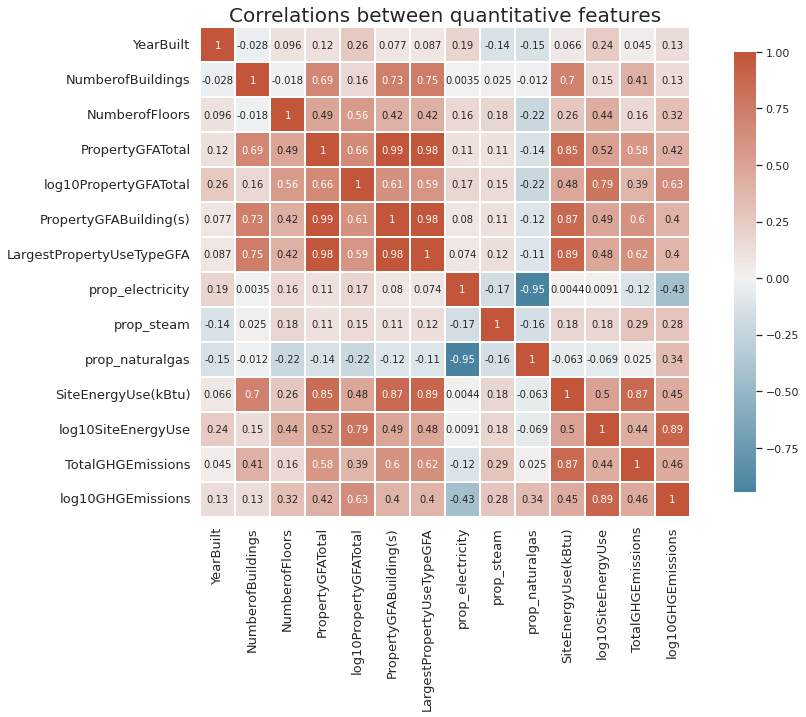

In [102]:
# compute the correlation matrix
corr = energy[quant_feat].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(
    corr, annot=True, annot_kws ={'size':10}, cmap=cmap, 
    vmax=1, center=0, square=True, linewidths=2, cbar_kws={"shrink": .9}
)

plt.gca().set_yticklabels(quant_feat)
plt.gca().set_xticklabels(quant_feat)
colormap.set_xticklabels(colormap.get_xmajorticklabels(), 
                         fontsize=13, rotation=90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), 
                         fontsize=13)

plt.title('Correlations between quantitative features', 
          fontsize=20);

### Creation of a new dataframe with only the features consistent with the analysis

- Selection of feature and target variables for the rest of the analysis
- We choose 'PropertyGFABuilding(s)' rather than 'PropertyGFATotal' because better correlations with the targets (not log)
- We choose 'PropertyGFABuilding(s)' rather than 'LargestPropertyUseTypeGFA' because 61 NaN
- We choose 'PrimaryPropertyType' rather than 'LargestPropertyUseType' because better eta squared with targets
- We choose 'Neighborhood' rather than 'CouncilDistrictCode' because better eta squared with the targets

In [103]:
# Create the new dataframe
energy = energy[[
    'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
    'NumberofFloors', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'prop_electricity',
    'prop_steam', 'prop_naturalgas', 'SiteEnergyUse(kBtu)',
    'log10SiteEnergyUse', 'TotalGHGEmissions', 'log10GHGEmissions'
]]

In [104]:
# Still missing values?
energy.isna().sum()

PrimaryPropertyType         0
Neighborhood                0
YearBuilt                   0
NumberofBuildings           0
NumberofFloors              3
PropertyGFAParking          0
PropertyGFABuilding(s)      0
ENERGYSTARScore           416
prop_electricity            0
prop_steam                  0
prop_naturalgas             0
SiteEnergyUse(kBtu)         0
log10SiteEnergyUse          0
TotalGHGEmissions           0
log10GHGEmissions           0
dtype: int64

In [105]:
# Replace NaN by the mean for 'NumberofFloors'
NaN_to_replace = ['NumberofFloors']

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
energy[NaN_to_replace] = imp_median.fit_transform(energy[NaN_to_replace])

# We do not remove the NaNs from the "ENERGYSTARScore" because we will create a dataframe at the very end without
# and a dataframe with for the study on its usefulness in GHG emission prediction

In [106]:
# Removal of "SPS-District K-12" and "Office" category properties because too few staff
# -> will cause problem during train_test_split post One-Hot-Encoder
indexName = energy.loc[
    (energy['PrimaryPropertyType'] == 'SPS-District K-12')|
    (energy['PrimaryPropertyType'] == 'Office')
].index

energy = energy.drop(indexName)

In [107]:
# Create a list of features without 'ENERGYSTARScore'
features = [
    'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
    'NumberofFloors', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'prop_electricity',
    'prop_steam', 'prop_naturalgas', 'SiteEnergyUse(kBtu)',
    'log10SiteEnergyUse', 'TotalGHGEmissions', 'log10GHGEmissions'
]

In [108]:
# Create a list of quantitative features without 'ENERGYSTARScore' & targets
quant_features = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'prop_electricity',
    'prop_steam', 'prop_naturalgas'
]

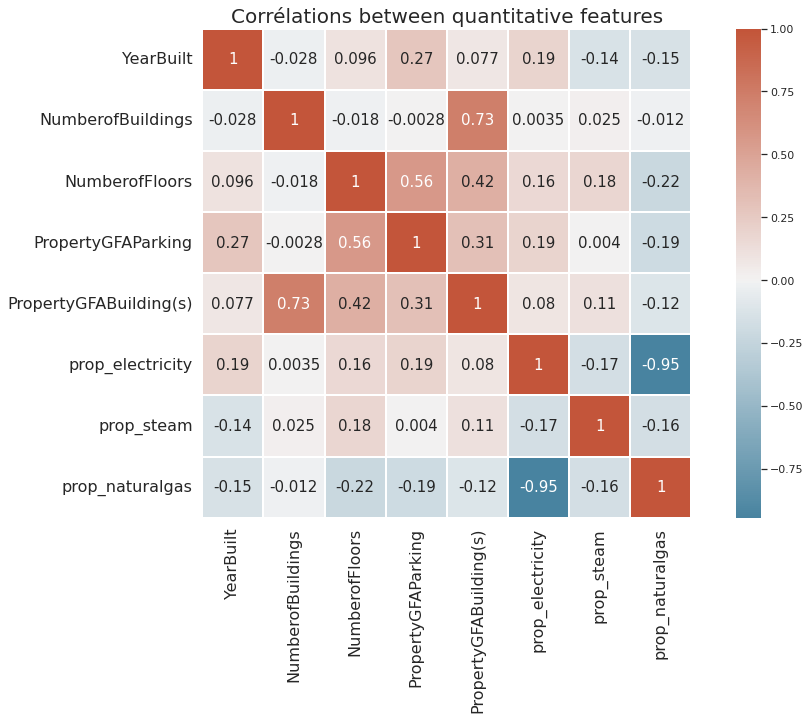

In [109]:
# compute the correlation matrix between quantitative features only
corr = energy[quant_features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(
    corr, annot=True, annot_kws ={'size':15}, cmap=cmap, 
    vmax=1, center=0, square=True, linewidths=2, cbar_kws={"shrink": 1}
)

colormap.set_xticklabels(colormap.get_xmajorticklabels(), 
                         fontsize=16, rotation=90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), 
                         fontsize=16)
plt.title('Corrélations between quantitative features', 
          fontsize=20);

### Création du dataframe en supprimant les NaN du "ENERGYSTARScore" afin de pouvoir évaluer son utilité pour la prédiction des GHGEmissions

In [110]:
# Remove lines containing NaN for variables
# which will be used in features:
NaN_to_drop = ['ENERGYSTARScore']

energy_star = energy.dropna(subset=NaN_to_drop)

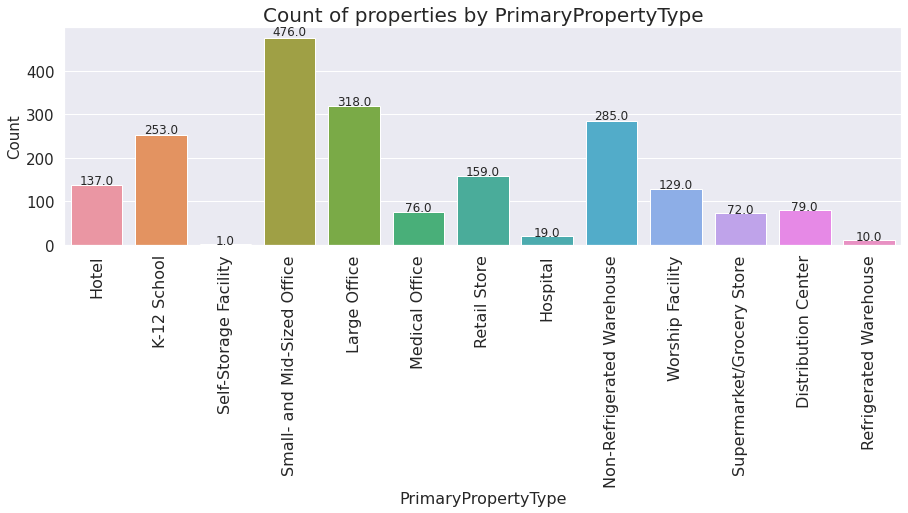

In [111]:
# Countplot of PrimaryPropertyType
display_countplot(energy_star, "PrimaryPropertyType")

In [112]:
# We delete the "Self-Storage Facility" property 
# because there are too few of them (only 1)
# for the subsequent train_test_split in particular
indexName = energy_star.loc[
    (energy_star['PrimaryPropertyType'] == 'Self-Storage Facility')
].index

energy_star = energy_star.drop(indexName)

In [113]:
# Create a list of quantitative features
quant_features = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'prop_electricity',
    'prop_steam', 'prop_naturalgas', 'TotalGHGEmissions', 'log10GHGEmissions'
]

In [114]:
# compute the correlation matrix
corr = energy_star[quant_features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(
    corr, annot=True, annot_kws ={'size':10}, cmap=cmap, 
    vmax=1, center=0, square=True, linewidths=2, cbar_kws={"shrink": .9}
)

colormap.set_xticklabels(colormap.get_xmajorticklabels(), 
                         fontsize=13, rotation=90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), 
                         fontsize=13)
plt.title('Correlation between quantitative features and ENERGYSTARScore', 
          fontsize=20);

### Creating a dataframe without outliers

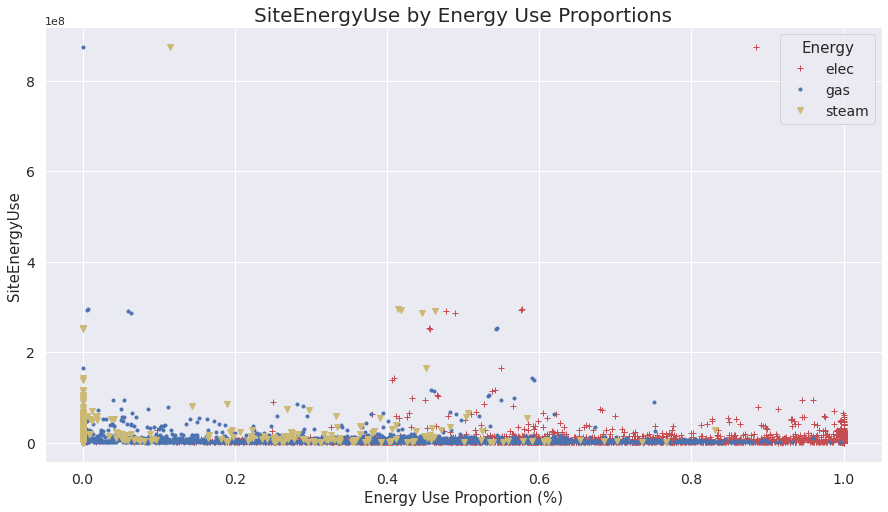

In [115]:
# Observation of the evolution of the SiteEnergyUse(kBtu) 
# according to the proportions of types of energy used
plt.figure(figsize=(15,8))
plt.plot(energy['prop_electricity'],energy['SiteEnergyUse(kBtu)'], "r+", label="elec")
plt.plot(energy['prop_naturalgas'],energy['SiteEnergyUse(kBtu)'], "b.", label="gas")
plt.plot(energy['prop_steam'],energy['SiteEnergyUse(kBtu)'], "yv", label="steam")
plt.legend(title="Energy", title_fontsize=15, fontsize=14, loc="upper right")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Energy Use Proportion (%)", size=15)
plt.ylabel("SiteEnergyUse", size=15)
plt.title("SiteEnergyUse by Energy Use Proportions", size=20)
plt.show()

**-> We will set the threshold at 2e8 for "SiteEnergyUse"**

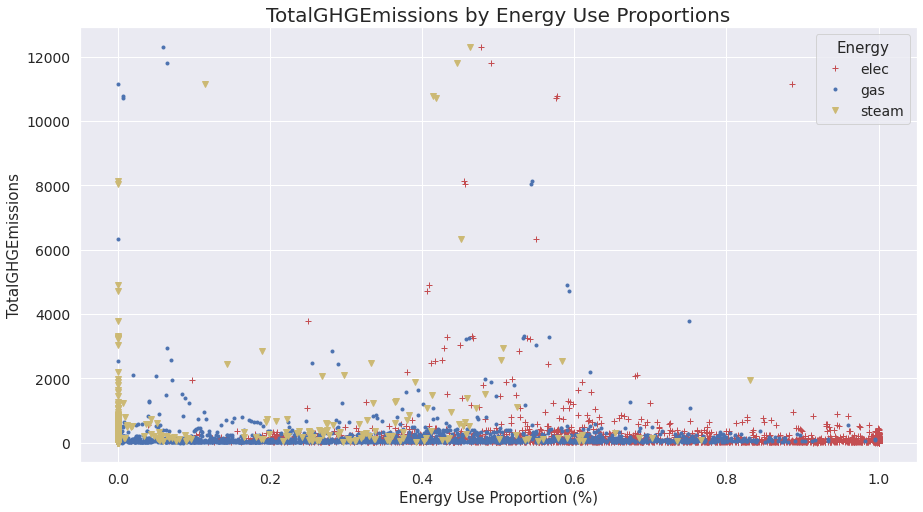

In [116]:
# Observation of the evolution of the TotalGHGEmissions 
# according to the proportions of types of energy used
plt.figure(figsize=(15,8))
plt.plot(energy['prop_electricity'],energy['TotalGHGEmissions'], "r+", label="elec")
plt.plot(energy['prop_naturalgas'],energy['TotalGHGEmissions'], "b.", label="gas")
plt.plot(energy['prop_steam'],energy['TotalGHGEmissions'], "yv", label="steam")
plt.legend(title="Energy", title_fontsize=15, fontsize=14, loc="upper right")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Energy Use Proportion (%)", size=15)
plt.ylabel("TotalGHGEmissions", size=15)
plt.title("TotalGHGEmissions by Energy Use Proportions", size=20)
plt.show()

**-> We will set the threshold at 4000 for "TotalGHGEmissions"**

In [117]:
# Creation of the dataframe without outliers
energy_no_outliers = energy.loc[
    (energy['SiteEnergyUse(kBtu)'] < 2e8)
    & (energy['TotalGHGEmissions'] < 4000)
]

In [118]:
# Calculate the number of deleted estates
deleted_estates = energy.shape[0] - energy_no_outliers.shape[0]
print(f"{deleted_estates} estates have been deleted")

10 estates have been deleted


In [119]:
# Save the 3 data sets
energy.to_csv('energy.csv', sep=';', index=False)

energy_star.to_csv('energy_star.csv', sep=';', index=False)

energy_no_outliers.to_csv('energy_no_outliers.csv', sep=';', index=False)

# Principal Components analysis

### Circle of correlations with all selected quantitative variables (without log)

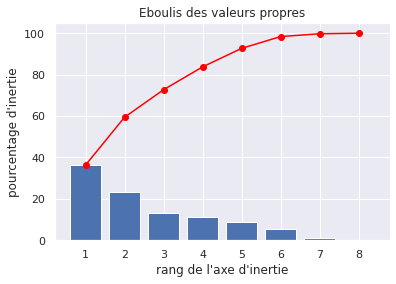

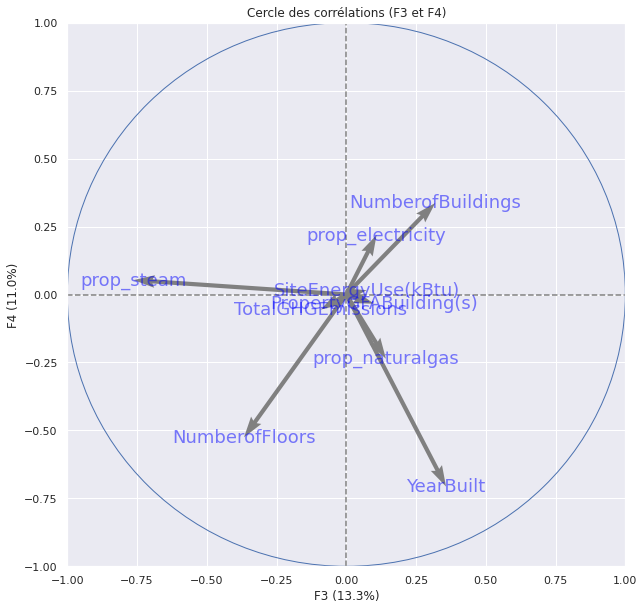

In [120]:
# Calculate principal components,
# print correlation circles and scree plot

# selection of the columns to be taken into account in the PCA
quant_feat = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFABuilding(s)', 'prop_electricity',
    'prop_steam', 'prop_naturalgas', 'SiteEnergyUse(kBtu)',
    'TotalGHGEmissions'
]

pca_correlation_scree(df=energy, list_columns=quant_feat)

### Circle of correlations without the energy proportion variables (for clarity)

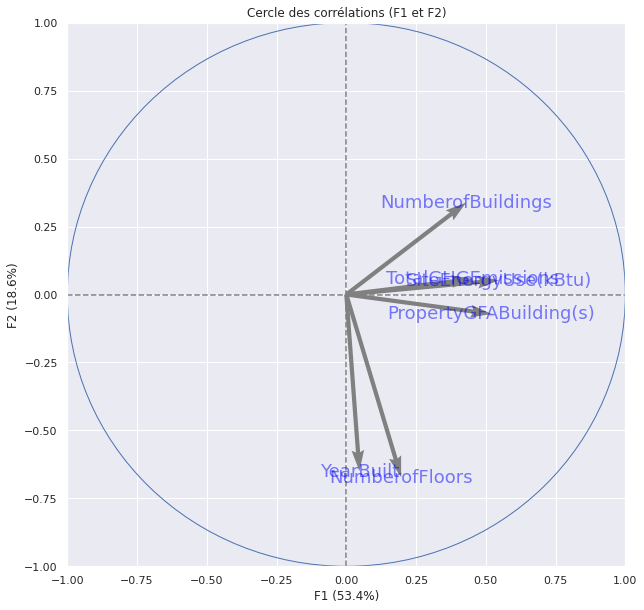

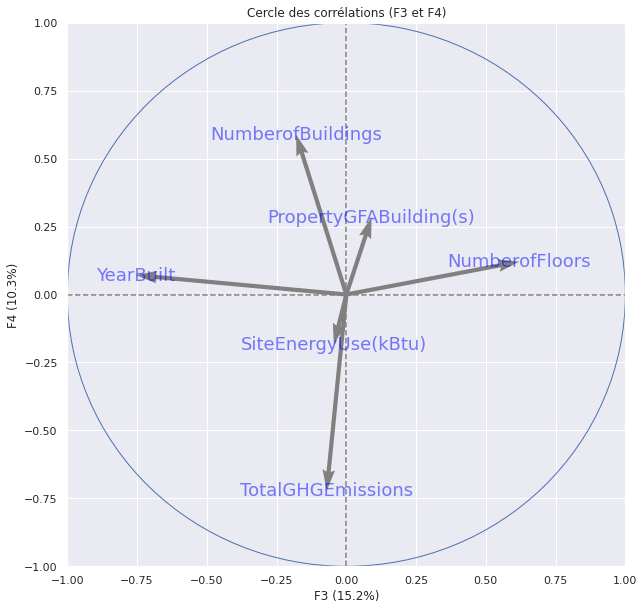

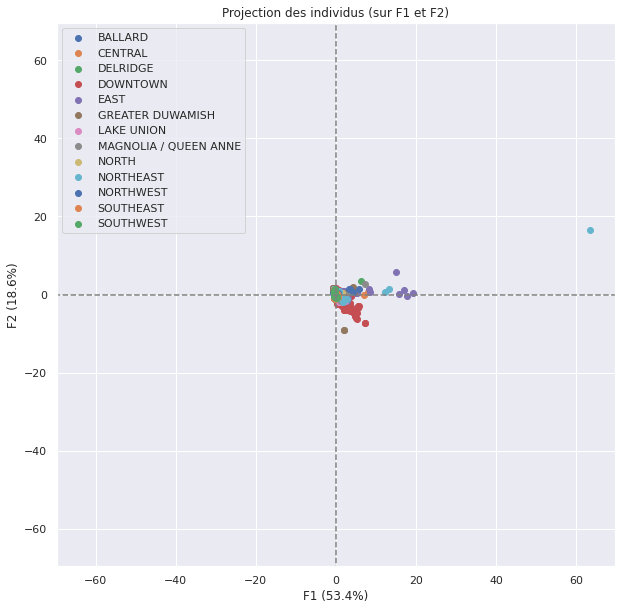

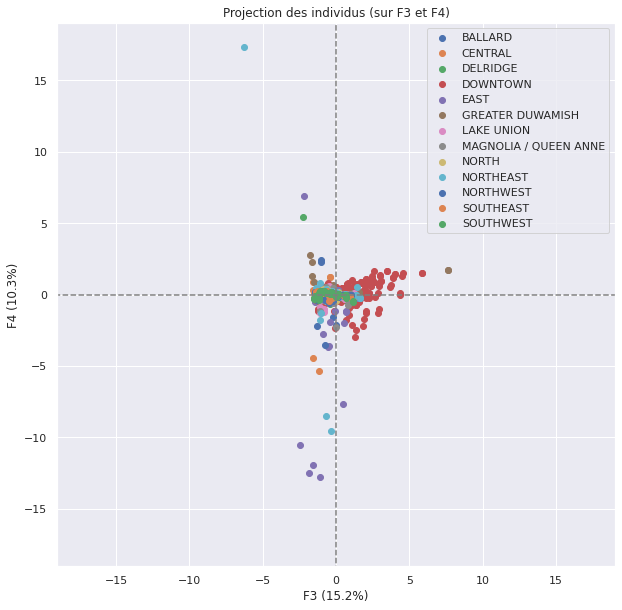

In [121]:
# Calculate principal components,
# print correlation circles and scree plot

# selection of the columns to be taken into account in the PCA
quant_feat = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'
]

pca_correlation_scree(df=energy, list_columns=quant_feat)

### Circle of correlations without declarative variables (size, floors, etc...)

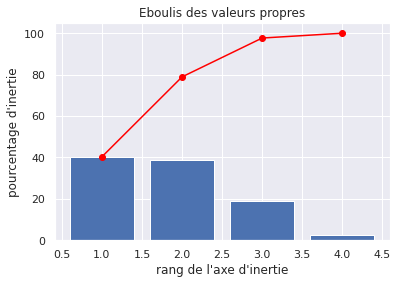

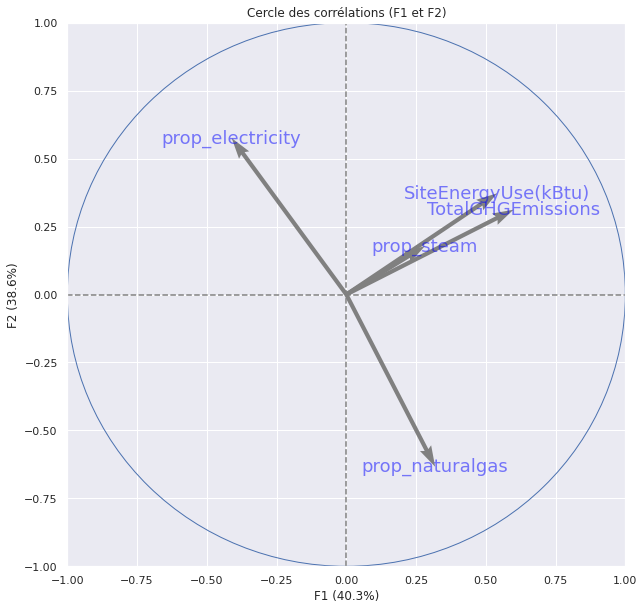

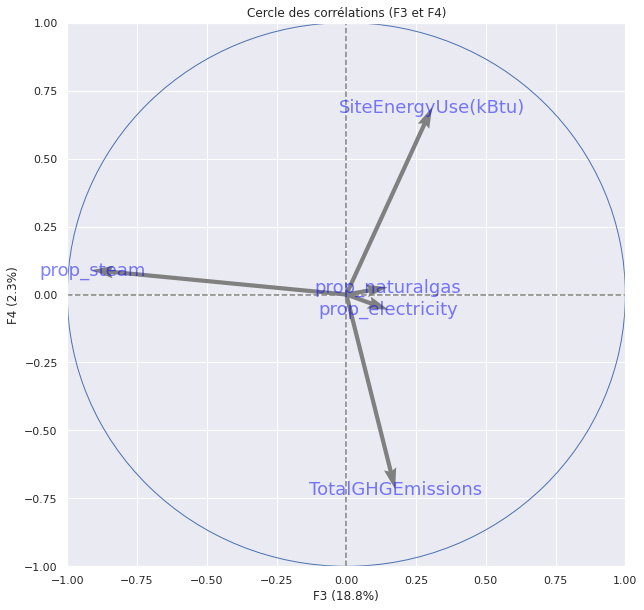

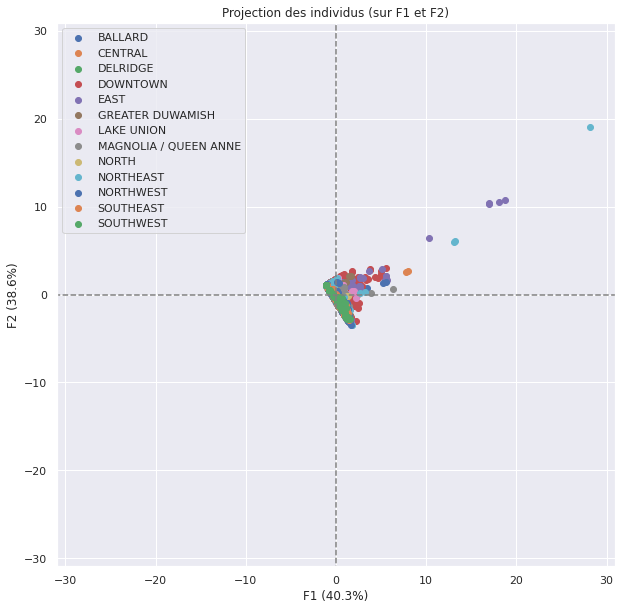

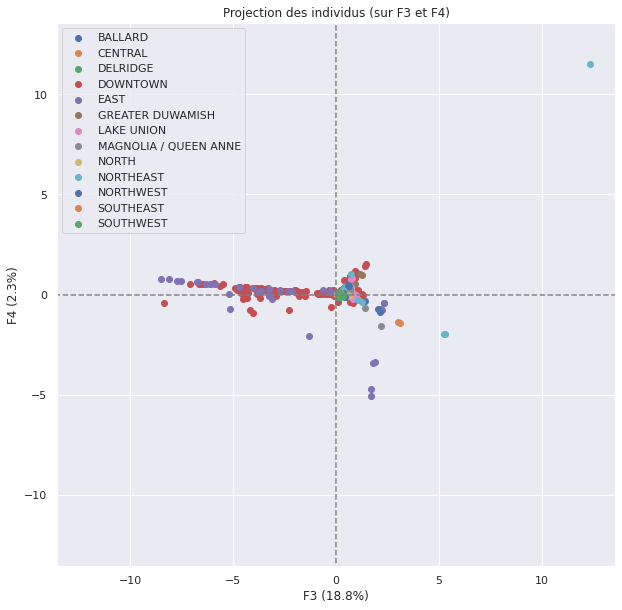

In [122]:
# Calculate principal components,
# print correlation circles and scree plot

# selection of the columns to be taken into account in the PCA
quant_feat = [
    'prop_electricity', 'prop_steam', 'prop_naturalgas',
    'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'
]

pca_correlation_scree(df=energy, list_columns=quant_feat)

### Circle of correlations to compare TotalGHGEmissions and ENERGYSTARScore

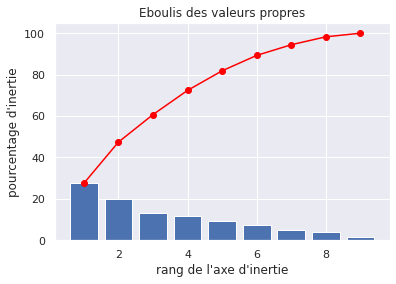

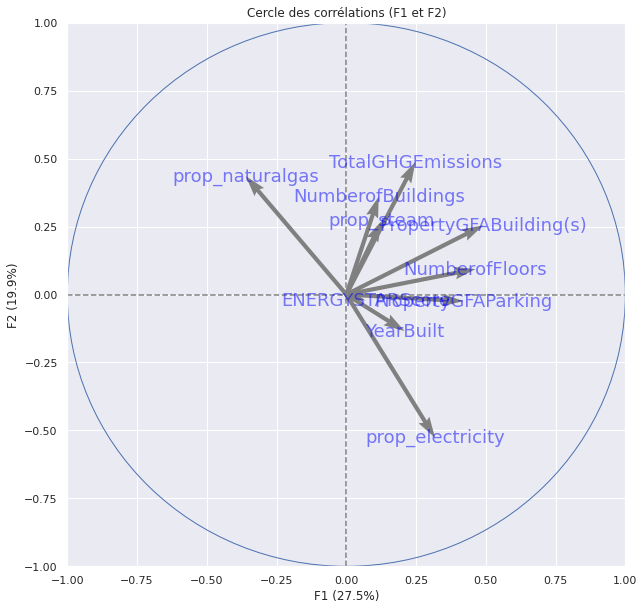

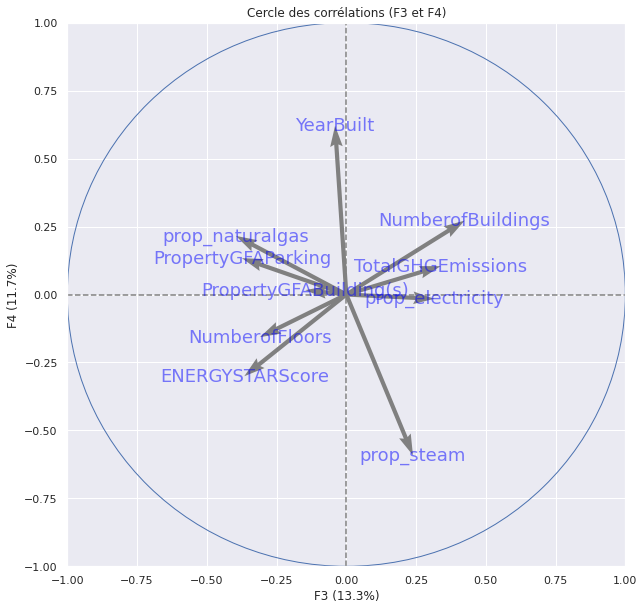

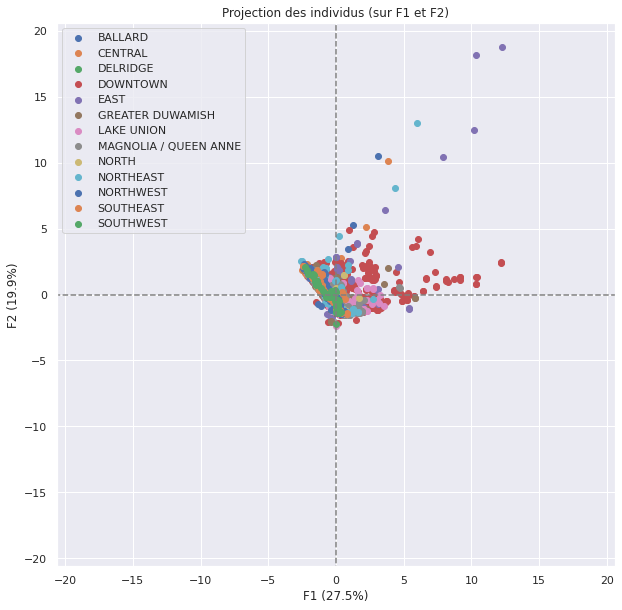

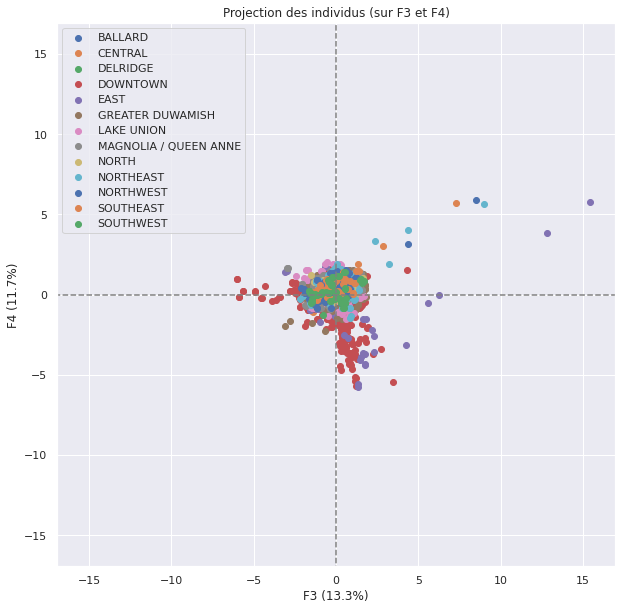

In [123]:
# Calculate principal components,
# print correlation circles and scree plot

# selection of the columns to be taken into account in the PCA
quant_feat = [
    'ENERGYSTARScore', 'YearBuilt', 'NumberofBuildings',
    'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'prop_electricity', 'prop_steam', 'prop_naturalgas',
    'TotalGHGEmissions'
]

pca_correlation_scree(df=energy_star, list_columns=quant_feat)

# End of Exploration and Cleaning

## Next notebook : Machine Learning - Prediction of SiteEnergyUse & TotalGHGEmissions and Evaluation